# FRETBursts - nsALEX/PIE example
## How to use data from nsALEX/PIE to correct single-molecule FRET data and to present information regarding dynamics using MFD & BVA plots 

*This notebook is part of a [tutorial series](https://github.com/OpenSMFS/FRETBursts_notebooks) for the [FRETBursts](http://opensmfs.github.io/FRETBursts/) burst analysis software.*

> For a step-by-step introduction to FRETBursts usage please refer to 
> [us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).
>
> In this notebook we present a typical [FRETBursts](http://opensmfs.github.io/FRETBursts/)
> workflow for **nsALEX/PIE smFRET burst analysis**. 

*While FRETBursts does not specifically includes functions for fitting 
TCSPC fluorescence decays, a fitting with exponential decays and 
IRF deconvolution can be easily performed using standard python libraries. 
For an example and a brief discussion see the notebook 
[Lifetime decay fit](http://nbviewer.ipython.org/github/tritemio/notebooks/blob/master/Lifetime_decay_fit.ipynb).*

## Loading FRETBursts

In [1]:
import os
import time
import concurrent.futures

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy.linalg import matrix_power

from fretbursts_dev import *
import lmfit as lm
import h5py

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7+29.gc9efe1a.dirty).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
sns = init_notebook()

Download sample data from https://zenodo.org/record/3569761/files/Sample%20Data.hdf5?download=1

In [3]:
filename = r'/home/paul/Python/HDF5/HP3_TE300_SPC630.hdf5'
filename

'/home/paul/Python/HDF5/HP3_TE300_SPC630.hdf5'

## Selecting a data file

Alternatively you can use an open-file dialog in order to select a data file:

In [4]:
if os.path.isfile(filename):
    print("Perfect, I found the file!")
else:
    print("Sorry, I can't find the file:\n%s" % filename)

Perfect, I found the file!


## Load the selected file

Here we load the file and we set the alternation parameters:

In [5]:
d = loader.photon_hdf5(filename)
#d = loader.nsalex(fname)

In [6]:
d.time_max

5009.352951850001

In [7]:
d.det_t

[array([0, 1, 1, ..., 1, 1, 1], dtype=uint8)]

In [8]:
print("Detector    Counts")
print("--------   --------")
for det, count in zip(*np.unique(d.det_t, return_counts=True)):
    print("%8d   %8d" % (det, count))

Detector    Counts
--------   --------
       0    6378957
       1    5457101


#### The PIE alternation period

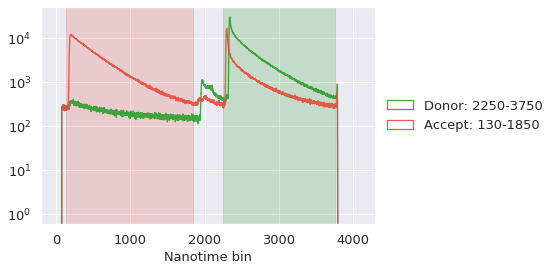

In [9]:
bpl.plot_alternation_hist(d)

Execute the previous 2 cells until you get a satisfying 
selection for the excitation periods. Then run the following 
to apply the parameters:

In [10]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):    11,414,157
#  D  photons in D+A excitation periods:    5,208,392
#  A  photons in D+A excitation periods:    6,205,765
# D+A photons in  D  excitation period:     6,611,308
# D+A photons in  A  excitation period:     4,802,849



## Burst search and selection
### Calculte the background rate for all photon streams, for each 30s chunk of the measurement

In [11]:
d.calc_bg(fun=bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... [DONE]


#### Plot of the mean BG rate for all photon streams ovr the whole acquisition time

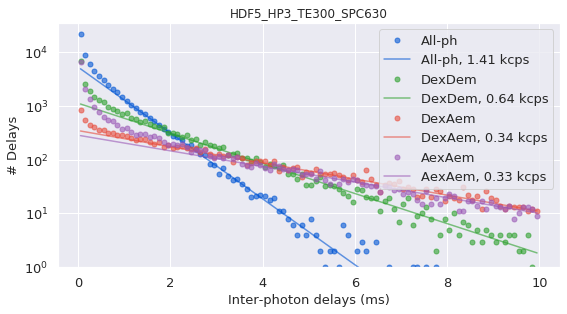

In [12]:
dplot(d, hist_bg, show_fit=True);

### Plot of how the BG rates of all photon streams change with acquistion time (30s bin)

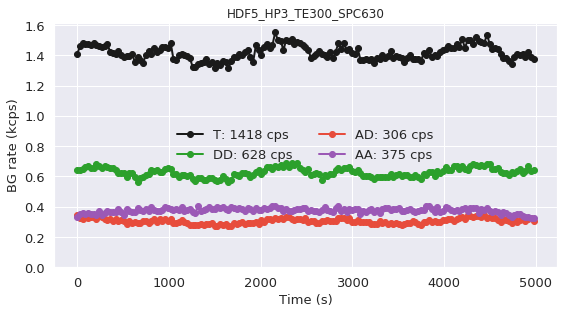

In [13]:
dplot(d, timetrace_bg)

#### A plot of a sample 1s binned data

(-100.0, 100.0)

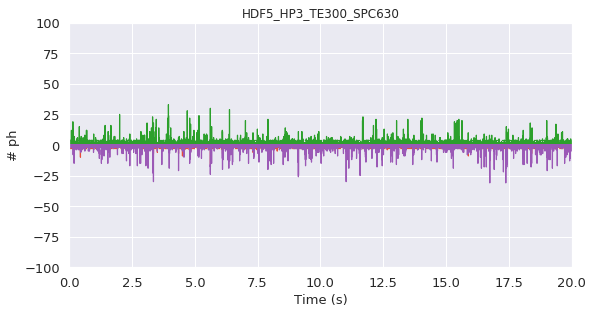

In [14]:
mxbin = 200

dplot(d, timetrace)
xlim(0, 20)
ylim(-1*mxbin/2, mxbin/2)
#dplot(d, timetrace)
#xlim(300, 600)
#ylim(-1*mxbin, mxbin)

### We start off by using All Channel Burst Search (ACBS), with no corrections

In [15]:
d.burst_search(m=10, F=6)
d.fuse_bursts(ms=0)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 35558 bursts (20.0%, 9 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A and FRET]


HDF5_HP3_TE300_SPC630 BS_all L10 m10 MR8 G1.000 BGexp-30s Fuse0.0ms bg Lk0.000 dir0.0

In [16]:
d.leakage = 0
d.dir_ex = 0
d.gamma = 1
d.beta = 1
ds_all = d.select_bursts(select_bursts.size, add_naa=True, th1=50)

   - Applying background correction.
   - Applying background correction.


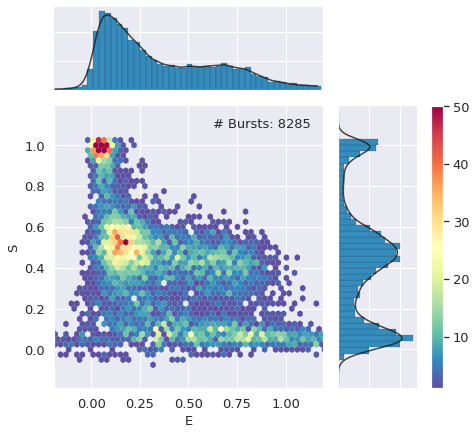

In [17]:
alex_jointplot(ds_all)
#plt.savefig('aSyn39C-ATTO488-39C-ATTO647N_1h_2D_ALEX_all.png', dpi=1200, bbox_inches='tight')

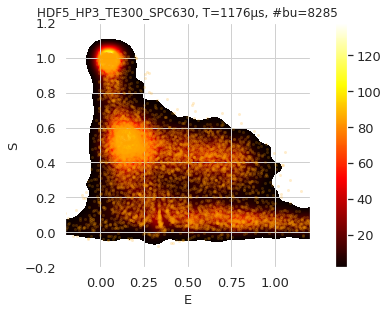

In [18]:
dplot(ds_all, hist2d_alex);

### Then, we select only the donor-only (DO) & acceptor-only (AO) populations

In [19]:
ds_DO = ds_all.select_bursts(select_bursts.S, S1=0.8)
ds_DO = ds_DO.select_bursts(select_bursts.E, E2=0.2)
ds_AO = ds_all.select_bursts(select_bursts.S, S2=0.1)

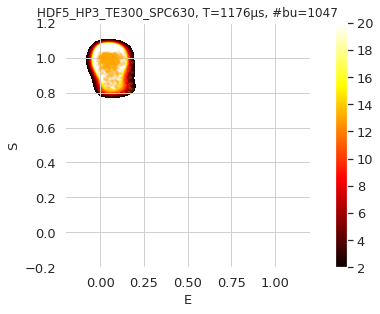

In [20]:
dplot(ds_DO, hist2d_alex);

#### The mean of the DO FRET histogram should be 0. A value >0 is an indication of leakage
We use this value to calculate the Leakage factor - donor fluorescence leakage to the acceptor detection channel

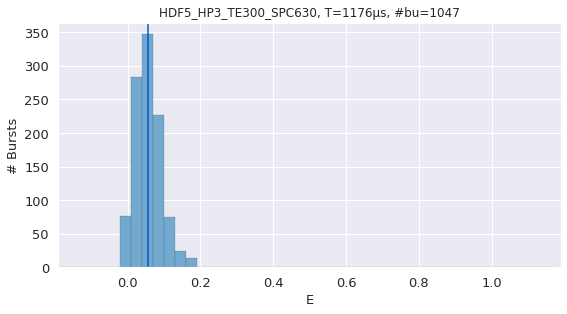

In [21]:
dplot(ds_DO, hist_fret, pdf=False)
plt.axvline(np.mean(ds_DO.E))

In [22]:
Lk = np.mean(ds_DO.E)/(1 - np.mean(ds_DO.E));
Lk

0.06033463072859452

#### The mean of the AO Stoichiometry histogram should be 0. A value >0 is an indication of leakage
We use this value to calculate the Direct acceptor excitation factor - acceptor fluorescence caused by excitation by the laser intended for donor excitation

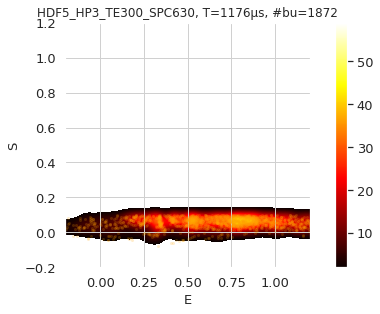

In [23]:
dplot(ds_AO, hist2d_alex);

0.04498565146056756

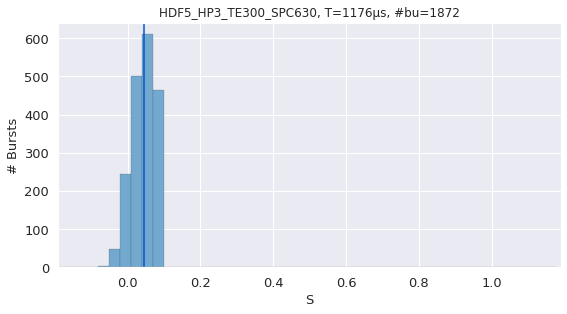

In [24]:
dplot(ds_AO, hist_S, pdf=False)
plt.axvline(np.mean(ds_AO.S))
np.mean(ds_AO.S)

In [25]:
Dir = np.mean(ds_AO.S)/(1 - np.mean(ds_AO.S));
Dir

0.04710468646818462

### After employing Lk & Dir corrections

In [26]:
d.leakage = Lk
d.dir_ex = Dir
d.gamma = 1
d.beta = 1
ds_all = d.select_bursts(select_bursts.size, add_naa=True, th1=30)

   - Applying background correction.
   - Applying leakage correction.
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


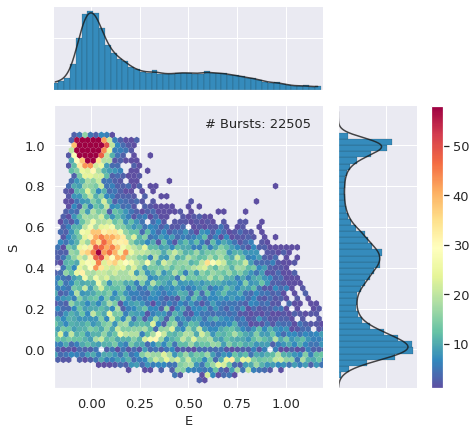

In [27]:
alex_jointplot(ds_all)


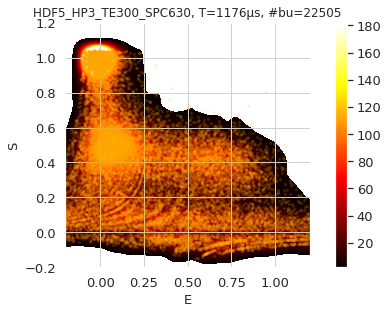

In [28]:
dplot(ds_all, hist2d_alex);

#### Then we check that applying Lk & Dir corrections yielded DO & AO populations with mean E/S value of 0

In [29]:
ds_DO = ds_all.select_bursts(select_bursts.S, S1=0.8)
ds_DO = ds_DO.select_bursts(select_bursts.E, E2=0.2)
ds_AO = ds_all.select_bursts(select_bursts.S, S2=0.1)
ds_F = ds_all.select_bursts(select_bursts.S, S1=0.2, S2=0.7)

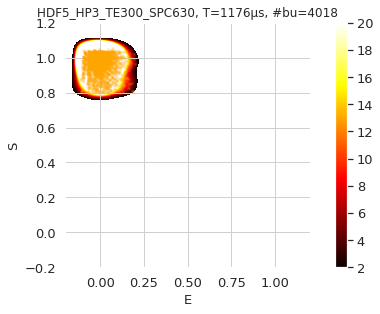

In [30]:
dplot(ds_DO, hist2d_alex);

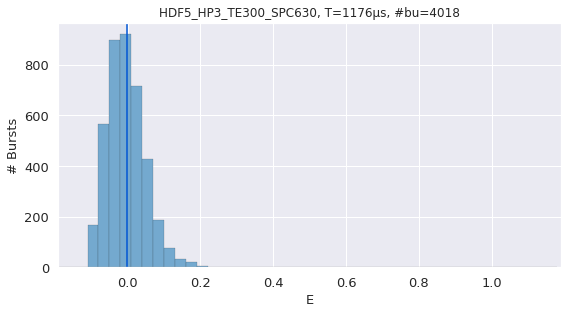

In [31]:
dplot(ds_DO, hist_fret, pdf=False)
plt.axvline(np.mean(ds_DO.E))

In [32]:
np.mean(ds_DO.E)

-0.0029395873502121067

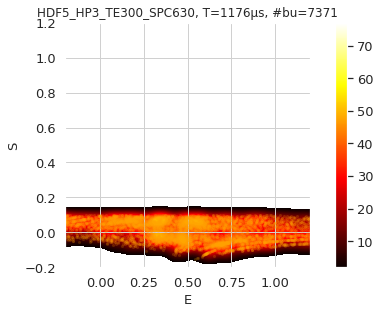

In [33]:
dplot(ds_AO, hist2d_alex);

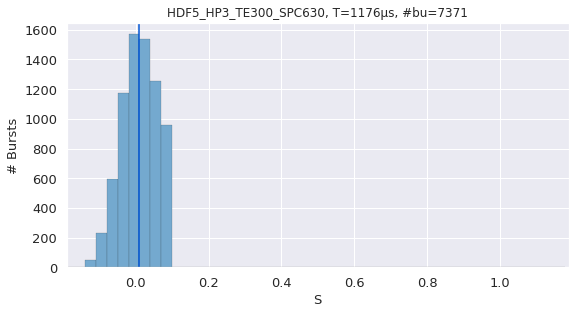

In [34]:
dplot(ds_AO, hist_S, pdf=False)
plt.axvline(np.mean(ds_AO.S))

In [35]:
np.mean(ds_AO.S)

0.010033038658634898

### We move on to calculate the Gamma factor using the donor lifetime information
#### for that we get the FRET population using Dual channel burst search (DCBS)

In [36]:
# DCBS
d_dcbs = bext.burst_search_and_gate(d, F = 6, m = 10)
# Fusion of consecutive bursts with less than m photons separating them
d_dcbs.fuse_bursts(ms=0)
# applying the correction factors acquired so far
d_dcbs.leakage = d.leakage
d_dcbs.dir_ex = d.dir_ex
d_dcbs.gamma = d.gamma
d_dcbs.beta = d.beta

Deep copy executed.
Deep copy executed.
Deep copy executed.
 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Performing burst search (verbose=False) ... - Recomputing background limits for AexAem ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 5855 bursts (20.6%, 8 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applyin

In [37]:
# Burst selection

gen_th = 40
# We first select bursts according to a burst size thresholds for ALL photon streams (DD, DA, AA)
# This step helps in haping the S population
ds_FRET = d_dcbs.select_bursts(select_bursts.size, add_naa=True, th1=gen_th)
# Then we select from them bursts according to a burst size threshold for burst streams after donor excitation (DD, DA)
# This step helps in shaping the E population
ds_FRET = ds_FRET.select_bursts(select_bursts.size, add_naa=False, th1=gen_th/2)
# Then we select from them bursts according to a burst size threshold for burst streams after acceptor excitation (AA)
# This step filters out the donor-only species and leaves us only with FRET species
ds_FRET = ds_FRET.select_bursts(select_bursts.naa, th1=gen_th/2)
#ds_FRET = ds_FRET.select_bursts(select_bursts.E, E1=0.5)

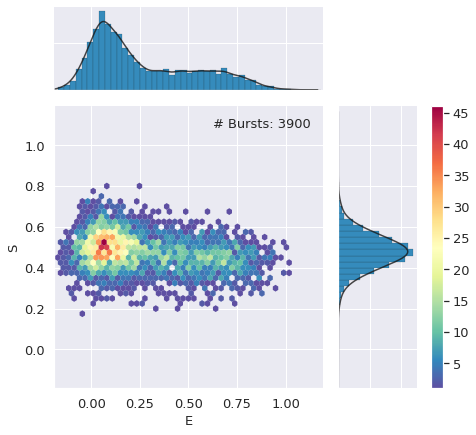

In [38]:
alex_jointplot(ds_FRET)


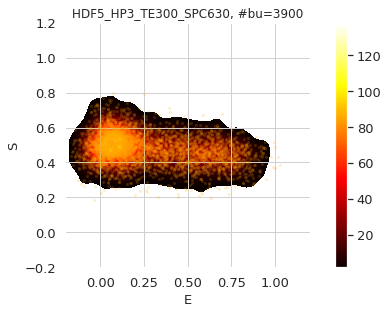

In [39]:
dplot(ds_FRET, hist2d_alex);

In [40]:
ds_FRET_low = ds_FRET.select_bursts(select_bursts.E, E2=0.3)
ds_FRET_high = ds_FRET.select_bursts(select_bursts.E, E1=0.5)

#### We keep the mean un-corrected FRET value for further use in the Gamma calculation

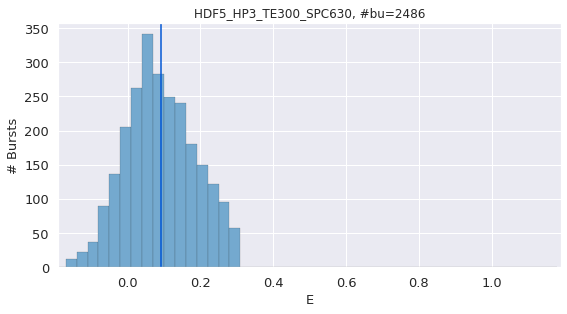

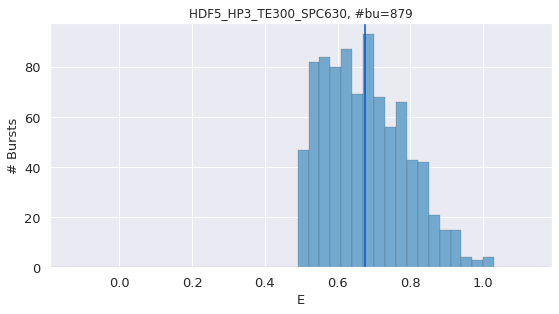

In [41]:
dplot(ds_FRET_low, hist_fret, pdf=False)
plt.axvline(np.mean(ds_FRET_low.E))
dplot(ds_FRET_high, hist_fret, pdf=False)
plt.axvline(np.mean(ds_FRET_high.E))

In [42]:
Eapp_low = np.mean(ds_FRET_low.E)
Eapp_high = np.mean(ds_FRET_high.E)
Eapp_low, Eapp_high

(0.09108397410964678, 0.6750652728945077)

## Calculating the Gamma factor, per FRET population, using the donor fluorescence nanotimes

In [43]:
# The TCSPC parameters are passed to the burst handler in FRETbursts nalysis of PIE data
d.nanotimes_params

[{'tcspc_unit': 1.22152268886566e-11,
  'tcspc_num_bins': 4096,
  'tcspc_range': 5.003356933593743e-08}]

In [44]:
def get_nanotimes(d, ph_sel):
    mask = d.ph_in_bursts_mask_ich(ph_sel=ph_sel)
    return d.nanotimes[0][mask]

In [45]:
# This sets the TCSPC parameters to be used in nanotime calculations
tcspc_bin = d.nanotimes_params[0]['tcspc_unit']
tcspc_range = d.nanotimes_params[0]['tcspc_range']
tcspc_num_bins = d.nanotimes_params[0]['tcspc_num_bins']
bins_raw = np.arange(0, tcspc_num_bins)

# Photon selections according to photon streams
ph_sel_d = Ph_sel(Dex='Dem')
ph_sel_a = Ph_sel(Dex='Aem')
ph_sel_aa = Ph_sel(Aex='Aem')


tcspc_bin, tcspc_range, tcspc_num_bins

(1.22152268886566e-11, 5.003356933593743e-08, 4096)

In [46]:
# Getting the nanotimes of different photon stream and different photon selections

# This is for the selected bursts solely of the FRET population(s) - ds_FRET
nanotimes_d_FRET_low = get_nanotimes(ds_FRET_low, ph_sel_d)
nanotimes_a_FRET_low = get_nanotimes(ds_FRET_low, ph_sel_a)
nanotimes_aa_FRET_low = get_nanotimes(ds_FRET_low, ph_sel_aa)

nanotimes_d_FRET_high = get_nanotimes(ds_FRET_high, ph_sel_d)
nanotimes_a_FRET_high = get_nanotimes(ds_FRET_high, ph_sel_a)
nanotimes_aa_FRET_high = get_nanotimes(ds_FRET_high, ph_sel_aa)

# This is for the selected bursts solely of the DO population - ds_DO
nanotimes_d_DO = get_nanotimes(ds_DO, ph_sel_d)
nanotimes_a_DO = get_nanotimes(ds_DO, ph_sel_a)

hist_params = dict(bins=bins_raw, density=False)
nanot_hist_d_FRET_low, _ = np.histogram(nanotimes_d_FRET_low, **hist_params)
nanot_hist_a_FRET_low, _ = np.histogram(nanotimes_a_FRET_low, **hist_params)
nanot_hist_aa_FRET_low, _ = np.histogram(nanotimes_aa_FRET_low, **hist_params)
nanot_hist_d_FRET_high, _ = np.histogram(nanotimes_d_FRET_high, **hist_params)
nanot_hist_a_FRET_high, _ = np.histogram(nanotimes_a_FRET_high, **hist_params)
nanot_hist_aa_FRET_high, _ = np.histogram(nanotimes_aa_FRET_high, **hist_params)
nanot_hist_d_DO, _ = np.histogram(nanotimes_d_DO, **hist_params)
nanot_hist_a_DO, _ = np.histogram(nanotimes_a_DO, **hist_params)

In [47]:
# Plotting the fluorescence decays of different photon selections & photon streams
bins_raw = np.arange(0, tcspc_num_bins)
time_axis_ns = (bins_raw[1:] * tcspc_bin) * 1e9


Text(0, 0.5, 'Counts')

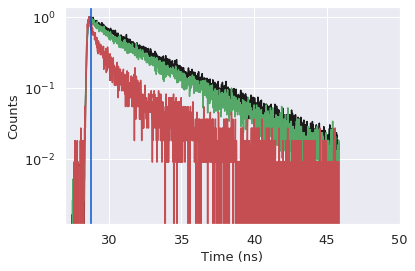

In [48]:
# Plotting the donor fluorescence decays of different photon selections
# In this case I chose to overlay the DO & FRET related donor fluorescence decays
plt.semilogy(time_axis_ns, nanot_hist_d_DO/np.max(nanot_hist_d_DO), 'k')
plt.semilogy(time_axis_ns, nanot_hist_d_FRET_low/np.max(nanot_hist_d_FRET_low), 'g')
plt.semilogy(time_axis_ns, nanot_hist_d_FRET_high/np.max(nanot_hist_d_FRET_high), 'r')

# For the purpose of calculting mean nanotimes, for a given excitation window (Dex. or Aex. in PIE)
# it is important to choose nanotimes larger than a given lower boundary value. 
# The optimal lower boundary value should be one in which the TCSPC histogram is in its decay part, after the IRF convolution part
# BUT, as low as possible to include as many photon nanotimes as possible in the mean nnotime calculation
plt.axvline(28.8)
plt.xlim(27,50)
plt.xlabel('Time (ns)')
plt.ylabel('Counts')

In [49]:
# Setting the value of the variable that will serve as the lower boundary for the nanotimes of photons belonging to Dex. photon streams
nt_th_Dex = 28.8

Text(0, 0.5, 'Counts')

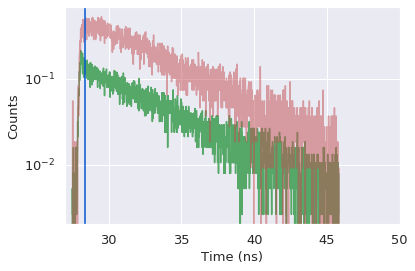

In [50]:
# Plotting the donor fluorescence decays of different photon selections
# In this case I chose to overlay the DO & FRET related donor fluorescence decays
plt.semilogy(time_axis_ns, nanot_hist_a_FRET_low/np.max(nanot_hist_d_FRET_low), 'g')
plt.semilogy(time_axis_ns, nanot_hist_a_FRET_high/np.max(nanot_hist_d_FRET_high), 'r', alpha=0.5)

# For the purpose of calculting mean nanotimes, for a given excitation window (Dex. or Aex. in PIE)
# it is important to choose nanotimes larger than a given lower boundary value. 
# The optimal lower boundary value should be one in which the TCSPC histogram is in its decay part, after the IRF convolution part
# BUT, as low as possible to include as many photon nanotimes as possible in the mean nnotime calculation
plt.axvline(28.4)
plt.xlim(27,50)
plt.xlabel('Time (ns)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

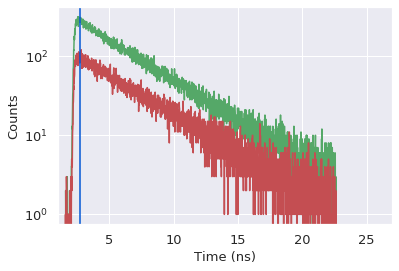

In [51]:
# Plotting the aceptor fluorescence decays of different photon selections
# In this case I chose to diplay the FRET-related acceptor fluorescence decay following acceptor excitation
plt.semilogy(time_axis_ns, nanot_hist_aa_FRET_low, 'g')
plt.semilogy(time_axis_ns, nanot_hist_aa_FRET_high, 'r')
# For the purpose of calculting mean nanotimes, for a given excitation window (Dex. or Aex. in PIE)
# it is important to choose nanotimes larger than a given lower boundary value. 
# The optimal lower boundary value should be one in which the TCSPC histogram is in its decay part, after the IRF convolution part
# BUT, as low as possible to include as many photon nanotimes as possible in the mean nnotime calculation
plt.axvline(2.7)
plt.xlim(1,27)
plt.xlabel('Time (ns)')
plt.ylabel('Counts')

In [52]:
# Setting the value of the variable that will serve as the lower boundary for the nanotimes of photons belonging to Aex. photon streams
nt_th_Aex = 2.7

#### gathering all nanotimes for all photon streams

In [53]:
def allocate_nanotimes(ds_tmp, tcspc_bin, nt_th_Dex, nt_th_Aex):
    
    bursts =ds_tmp.mburst[0]# This grants access to the bursts photons, including to their nanotimes
    # Define photon masks for the 3 main photon streams in PIE
    DexDem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))   
    DexAem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))   
    AexAem_mask = ds_tmp.get_ph_mask(ph_sel=Ph_sel(Aex='Aem'))   


    # Arrays that will hold the mean nanotime values
    nDexDm_corr=[]# for the stream of donor photons after donor excitation
    nDexAm_corr=[]# for the stream of acceptor photons after donor excitation
    nAexAm_corr=[]# for the stream of acceptor photons after acceptor excitation

    # Arrays that will hold the corresponding ratiometric values of E & S
    E_corr=[]
    S_corr=[]

    # Loop over all bursts
    for burst in bursts:
        #Set temporary summing variables - used as numerator in the calculations of the burst algebraic average
        tmpDA = 0;
        tmpAA = 0;
        tmpDD = 0;

        #Set temporary counter variables - used as denominator in the calculations of the burst algebraic average
        cntDA = 0;
        cntAA = 0;
        cntDD = 0;

        # For each burst, loop over its photons
        for i in range(burst.istart, burst.istop):
            # the current photon's nanotime in TCSPC bins units
            cur_nt = ds_tmp.nanotimes[0][i];
            # the current photon's nanotime in nanoseconds
            cur_nt = cur_nt * tcspc_bin * 1e9;

            # The case of a Dex.Dem. photon
            if DexDem_mask[i] == 1 and DexAem_mask[i] == 0 and AexAem_mask[i] == 0 and cur_nt > nt_th_Dex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
                tmpDD += cur_nt;
                cntDD += 1;
            # The case of a Dex.Aem. photon
            elif DexDem_mask[i] == 0 and DexAem_mask[i] == 1 and AexAem_mask[i] == 0 and cur_nt > nt_th_Dex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
                tmpDA += cur_nt;
                cntDA += 1;
            # The case of a Aex.Aem. photon
            elif DexDem_mask[i] == 0 and DexAem_mask[i] == 0 and AexAem_mask[i] == 1 and cur_nt > nt_th_Aex:# only consider photon nanotimes larger than a given lower boundary, defining the beginning of the decay part of the TCSPC histogram
                tmpAA += cur_nt;
                cntAA += 1;

        # The calculation of the mean nanotime for each photon stream in PIE
        # This conditional makes sure there were photons of the given photon stream in the burst. If there were no photons of that photon strem in the given burst, a value of -1 is stored instead.
        # The -1 values should be ignored afterwards in further calculations
        # Anyway, valid mean nanotimes are always larger or equl to 0

        # Dex.Dem. calculation
        if cntDD > 0:
            #The calcultion of the algebraic average nanotime 
            cur_mean_nt_DD = tmpDD/cntDD;
            # The mean nanotime has a value relative to the beginning of the decay part of the TCSPC histogram. 
            # Subtraction of this value makes the value of the mean nanotime become relative to 0, as it hould be.
            cur_mean_nt_DD = cur_mean_nt_DD - nt_th_Dex;
        else:
            cur_mean_nt_DD = -1;

        # Dex.Aem. calculation
        if cntDA > 0:
            cur_mean_nt_DA = tmpDA/cntDA;
            cur_mean_nt_DA = cur_mean_nt_DA - nt_th_Dex;
        else:
            cur_mean_nt_DA = -1;

        # Aex.Aem. calculation
        if cntAA > 0:
            cur_mean_nt_AA = tmpAA/cntAA;
            cur_mean_nt_AA = cur_mean_nt_AA - nt_th_Aex;
        else:
            cur_mean_nt_AA = -1;


        # Storing the mean nanotime values of the 3 different photons streams in PIE, in their arrays, per each burst
        nDexDm_corr.append(cur_mean_nt_DD)
        nDexAm_corr.append(cur_mean_nt_DA)
        nAexAm_corr.append(cur_mean_nt_AA)

    # Looping over all bursts to store the ratiometric E & S values
    for j in range(0, len(ds_tmp.E[0])):
        E_corr.append(ds_tmp.E[0][j])
        S_corr.append(ds_tmp.S[0][j])


    return [nDexDm_corr, nDexAm_corr, nAexAm_corr, E_corr, S_corr]

In [54]:
nDexDm_FRET_low, nDexAm_FRET_low, nAexAm_FRET_low, E_FRET_low, S_FRET_low = allocate_nanotimes(ds_FRET_low, tcspc_bin, nt_th_Dex, nt_th_Aex)

# Sanity check to test that the number of array elements for the mean nanotimes and E & S are identical
assert(len(nDexDm_FRET_low)==len(nDexAm_FRET_low)==len(nAexAm_FRET_low)==len(E_FRET_low)==len(S_FRET_low))



nDexDm_FRET_high, nDexAm_FRET_high, nAexAm_FRET_high, E_FRET_high, S_FRET_high = allocate_nanotimes(ds_FRET_high, tcspc_bin, nt_th_Dex, nt_th_Aex)

# Sanity check to test that the number of array elements for the mean nanotimes and E & S are identical
assert(len(nDexDm_FRET_high)==len(nDexAm_FRET_high)==len(nAexAm_FRET_high)==len(E_FRET_high)==len(S_FRET_high))



nDexDm_DO, nDexAm_DO, nAexAm_DO, E_DO, S_DO = allocate_nanotimes(ds_DO, tcspc_bin, nt_th_Dex, nt_th_Aex)

# Sanity check to test that the number of array elements for the mean nanotimes and E & S are identical
assert(len(nDexDm_DO)==len(nDexAm_DO)==len(nAexAm_DO)==len(E_DO)==len(S_DO))

##### Plots of the donor nanotime histograms - DO & FRET populations

Text(0.5, 1.0, 'Mean donor nanotimes - DO vs. FRET')

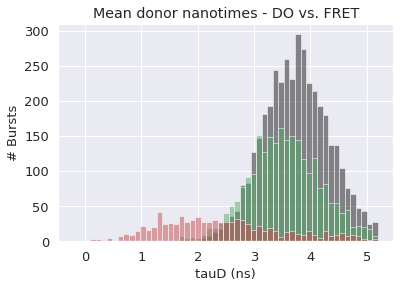

In [55]:
plt.hist(nDexDm_DO, bins=55, range=[-0.2,5.2], alpha=0.5, color='k');
plt.hist(nDexDm_FRET_low, bins=55, range=[-0.2,5.2], alpha=0.5, color='g');
plt.hist(nDexDm_FRET_high, bins=55, range=[-0.2,5.2], alpha=0.5, color='r');
plt.xlabel('tauD (ns)')
plt.ylabel('# Bursts')
plt.title('Mean donor nanotimes - DO vs. FRET')

#### calculating the mean donor fluorescence lifetimes and the corrected FRET efficiency
the nanotimes of the photons belonging to the DO & FRET selected bursts are used for calculating the mean of all bursts' mean nanotimes. Then we used them to calculate an etimate for the accurate FRET efficiency.

In [56]:
# The mean value of all mean nanotimes of all bursts of the DO population
mean_DD_DO = np.mean(nDexDm_DO)
# The mean value of all mean nanotimes of all bursts of the FRET population
mean_DD_FRET_low = np.mean(nDexDm_FRET_low)
mean_DD_FRET_high = np.mean(nDexDm_FRET_high)
# Using the mean donor lifetimes to estimate the corrected value of the FRET efficiency
mean_FRET_low = 1 - mean_DD_FRET_low / mean_DD_DO
mean_FRET_high = 1 - mean_DD_FRET_high / mean_DD_DO
# Plotting the values of the mean donor lifetimes of the DO & the FRET population, and the mean FRET fficiency
mean_DD_DO, mean_DD_FRET_low, mean_DD_FRET_high, mean_FRET_low, mean_FRET_high

(3.7654193995100145,
 3.567028276437548,
 2.509341210131193,
 0.05268765628027583,
 0.3335825458227235)

### The Gamma factor value is...
#### This is the procedure of estimating the Gamma factor from the un-corrected FRET efficiency (from FRET histogram) and from the estimate of the accurate mean FRET efficiency, calculated from donor nanotime data

In [57]:
gm_low = ((1-mean_FRET_low)/mean_FRET_low)/((1-Eapp_low)/Eapp_low)
gm_high = ((1-mean_FRET_high)/mean_FRET_high)/((1-Eapp_high)/Eapp_high)
gm_low, gm_high

(1.8017831718449793, 4.150426076921338)

In [58]:
gm = 1.8

### After employing Lk, Dir & Gamma corrections

In [59]:
d.leakage = Lk
d.dir_ex = Dir
d.gamma = gm
# We employ all correction factors, except Beta. We want to check wheather Beta should be larger or smaller than 1
d.beta = 1
ds_all = d.select_bursts(select_bursts.size, add_naa=True, th1=30)

   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


In [60]:
d_dcbs = bext.burst_search_and_gate(d, F = 6, m = 10)
d_dcbs.fuse_bursts(ms=0)
d_dcbs.leakage = d.leakage
d_dcbs.dir_ex = d.dir_ex
d_dcbs.gamma = d.gamma
d_dcbs.beta = d.beta

Deep copy executed.
Deep copy executed.
Deep copy executed.
 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Performing burst search (verbose=False) ... - Recomputing background limits for AexAem ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 5855 bursts (20.6%, 8 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applyin

In [61]:
# This time, burst selection has also to take into account burst sizes corrected by the Gamma factor
gen_th = 40
ds_FRET = d_dcbs.select_bursts(select_bursts.size, add_naa=True, th1=gen_th, gamma = d.gamma, beta = d.beta)
ds_FRET = ds_FRET.select_bursts(select_bursts.size, add_naa=False, th1=gen_th/2, gamma = d.gamma, beta = d.beta)
ds_FRET = ds_FRET.select_bursts(select_bursts.naa, th1=gen_th/2, gamma = d.gamma, beta = d.beta)

0.566753753434227

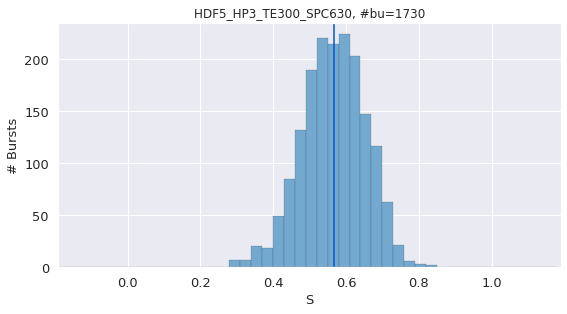

In [62]:
dplot(ds_FRET, hist_S, pdf=False)
plt.axvline(np.mean(ds_FRET.S))
np.mean(ds_FRET.S)

In our case, the mean S value of the FRET population, after applying all corrections (except for Beta) was different than 0.5 
##### If after all corrections the mean S value of the FRET population is <0.5, beta should be >1
##### If after all corrections the mean S value of the FRET population is >0.5, beta should be <1

In [63]:
d.leakage = Lk
d.dir_ex = Dir
d.gamma = gm
# We employ all correction factors, except Beta, 
# and then guess a number for Beta, until the Corrected mean Stoichiometry value reaches a value of 0.5
d.beta = 0.69
# Burst selection including all types of populations
ds_all = d.select_bursts(select_bursts.size, add_naa=True, th1=30, gamma=d.gamma, beta=d.beta)

   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


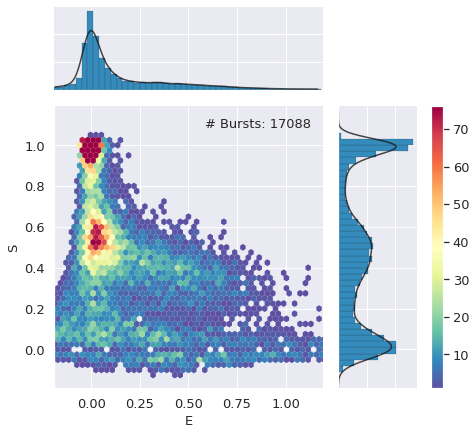

In [64]:
alex_jointplot(ds_all)

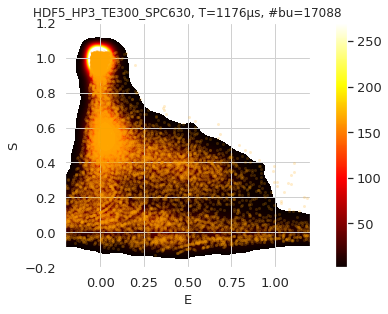

In [65]:
dplot(ds_all, hist2d_alex);

### Testing how well the Lk & Dir corrections worked after applying all corrections

In [66]:
ds_DO = ds_all.select_bursts(select_bursts.S, S1=0.8)
ds_DO = ds_DO.select_bursts(select_bursts.E, E2=0.2)
ds_AO = ds_all.select_bursts(select_bursts.S, S2=0.1)

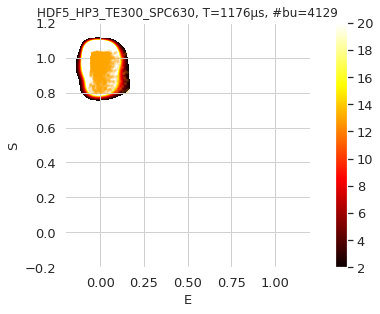

In [67]:
dplot(ds_DO, hist2d_alex);

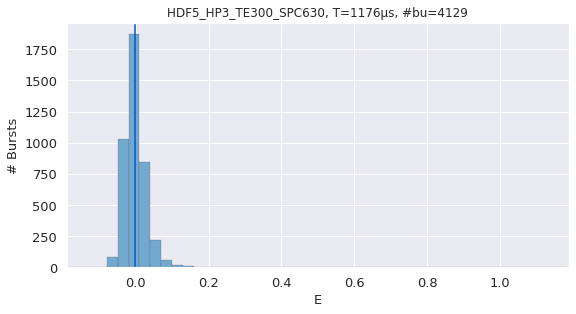

In [68]:
dplot(ds_DO, hist_fret, pdf=False)
plt.axvline(np.mean(ds_DO.E))

In [69]:
np.mean(ds_DO.E)

-0.0024529812567077925

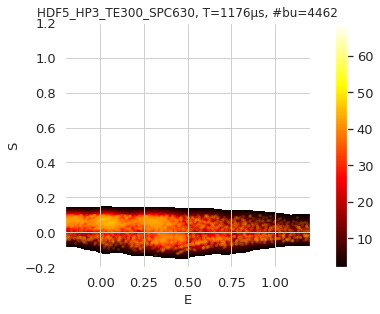

In [70]:
dplot(ds_AO, hist2d_alex);

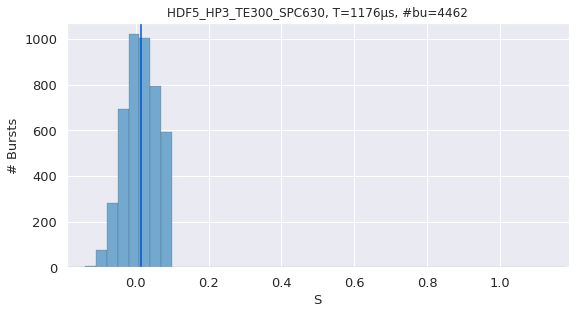

In [71]:
dplot(ds_AO, hist_S, pdf=False)
plt.axvline(np.mean(ds_AO.S))

In [72]:
np.mean(ds_AO.S)

0.014642451829274171

### Testing how well the Beta correction worked after applying all corrections

In [73]:
d_dcbs = bext.burst_search_and_gate(d, F = 6, m = 10)
d_dcbs.fuse_bursts(ms=0)
d_dcbs.leakage = d.leakage
d_dcbs.dir_ex = d.dir_ex
d_dcbs.gamma = d.gamma
d_dcbs.beta = d.beta

Deep copy executed.
Deep copy executed.
Deep copy executed.
 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Performing burst search (verbose=False) ... - Recomputing background limits for AexAem ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 5855 bursts (20.6%, 8 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applyin

In [74]:
# This time, burst selection has also to take into account burst sizes corrected by theBeta & Gamma factors
gen_th = 40
ds_FRET = d_dcbs.select_bursts(select_bursts.size, add_naa=True, th1=gen_th, gamma = d.gamma, beta = d.beta)
ds_FRET = ds_FRET.select_bursts(select_bursts.size, add_naa=False, th1=gen_th/2, gamma = d.gamma, beta = d.beta)
ds_FRET = ds_FRET.select_bursts(select_bursts.naa, th1=gen_th/2, gamma = d.gamma, beta = d.beta)

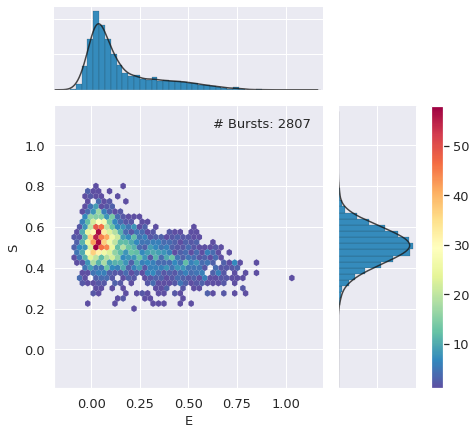

In [75]:
alex_jointplot(ds_FRET)


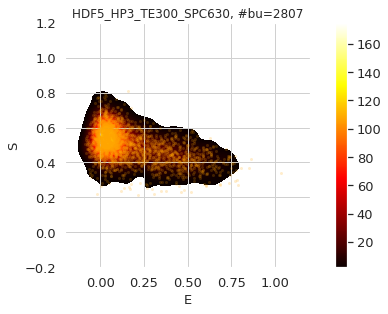

In [76]:
dplot(ds_FRET, hist2d_alex);

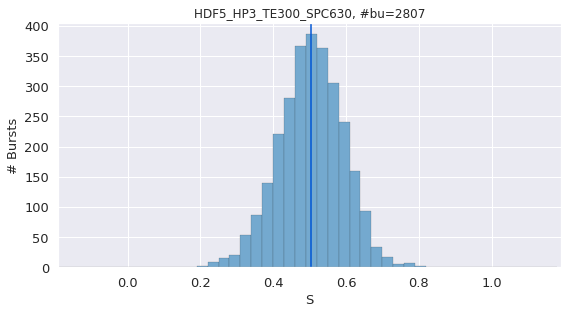

In [77]:
dplot(ds_FRET, hist_S, pdf=False)
plt.axvline(np.mean(ds_FRET.S))

#### At this stage, reaching a FRET population with a mean S value of 0.5, means we found the value of beta and the results are now corrected

In [78]:
np.mean(ds_FRET.S)

0.5048026047227956

In [79]:
ds_FRET.leakage, ds_FRET.dir_ex, ds_FRET.gamma, ds_FRET.beta

(array(0.06033463), 0.04710468646818462, array(1.8), 0.69)

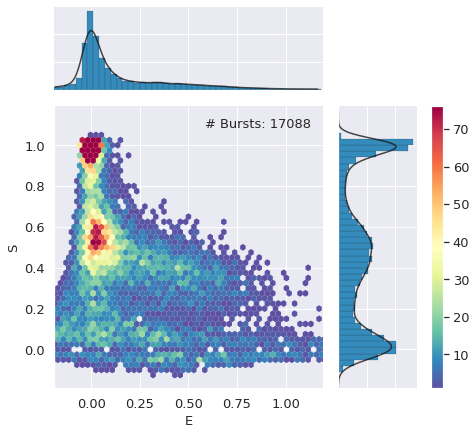

In [80]:
alex_jointplot(ds_all)

In [81]:
# This time, burst selection has also to take into account burst sizes corrected by theBeta & Gamma factors
gen_th = 40
ds_FRET = d_dcbs.select_bursts(select_bursts.size, add_naa=True, th1=gen_th, gamma = d.gamma, beta = d.beta)
ds_FRET = ds_FRET.select_bursts(select_bursts.size, add_naa=False, th1=gen_th/2, gamma = d.gamma, beta = d.beta)
ds_FRET = ds_FRET.select_bursts(select_bursts.naa, th1=gen_th/2, gamma = d.gamma, beta = d.beta)

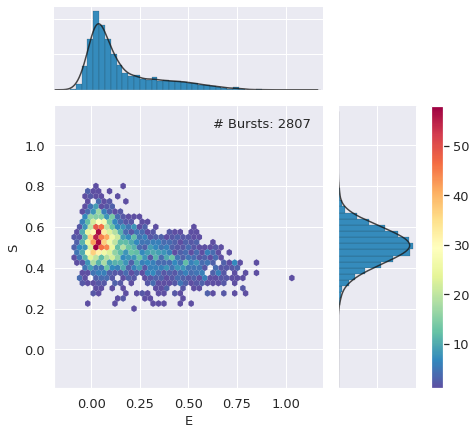

In [82]:
alex_jointplot(ds_FRET)

#### Here is the fully corrected FRET histogram

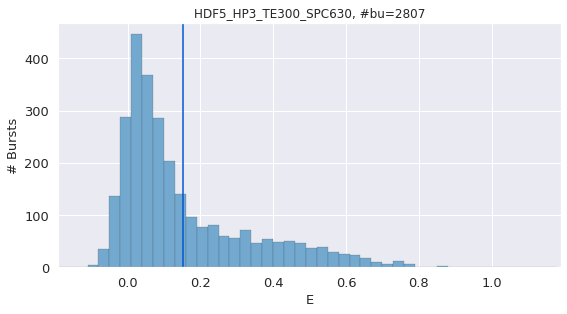

In [83]:
dplot(ds_FRET, hist_fret, pdf=False)
plt.axvline(np.mean(ds_FRET.E))

### Fitting the FRET histogram

In [84]:
import lmfit
print('lmfit version:', lmfit.__version__)

lmfit version: 1.0.1


#### Single Gaussian

In [85]:
model = mfit.factory_gaussian()
model.print_param_hints()

Name          Value      Min      Max     Vary    Expr    
amplitude         1     -inf      inf     True    
center          0.1       -1        2     True    
fwhm            nan     -inf      inf     True    2.3548200*sigma
height          nan     -inf      inf     True    0.3989423*amplitude/max(2.220446049250313e-16, sigma)
sigma           0.1        0      inf     True    


In [86]:
model.set_param_hint('center', value=0.2, min=-0.1, max=1.1)
model.set_param_hint('sigma', value=0.04, min=0, max=1)

In [87]:
E_fitter = bext.bursts_fitter(ds_FRET, 'E', binwidth=0.03)
E_fitter.fit_histogram(model=model, pdf=False, method='nelder')
E_fitter.fit_histogram(model=model, pdf=False, method='leastsq')

ValueError: could not broadcast input array from shape (5) into shape (3)

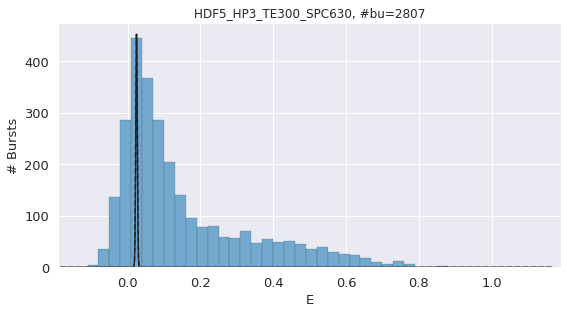

In [88]:
dplot(ds_FRET, hist_fret, show_model=True, pdf=False);

In [89]:
res = E_fitter.fit_res[0]
res.params.pretty_print()
print(res.fit_report(min_correl=0.5))

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude     2.393     -inf      inf     None     True     None     None
center      0.02461     -0.1      1.1     None     True     None     None
fwhm       0.004955     -inf      inf     None    False 2.3548200*sigma     None
height        453.6     -inf      inf     None    False 0.3989423*amplitude/max(2.220446049250313e-16, sigma)     None
sigma      0.002104        0        1     None     True     None     None
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 174
    # data points      = 46
    # variables        = 3
    chi-square         = 432149.000
    reduced chi-square = 10049.9767
    Akaike info crit   = 426.802679
    Bayesian info crit = 432.288603
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pi

In [90]:
ci = res.conf_interval()
lmfit.report_ci(ci)

MinimizerException: Cannot determine Confidence Intervals without sensible uncertainty estimates

#### Sum of 2 Gaussian

In [91]:
model = mfit.factory_two_gaussians()
model.print_param_hints()

Name             Value      Min      Max     Vary    Expr    
p1_amplitude         1     0.01      inf     True    
p1_center          0.1       -1        2     True    
p1_fwhm            nan     -inf      inf     True    2.3548200*p1_sigma
p1_height          nan     -inf      inf     True    0.3989423*p1_amplitude/max(2.220446049250313e-16, p1_sigma)
p1_sigma          0.03     0.01      0.2     True    
p2_amplitude         1     0.01      inf     True    
p2_center          0.9       -1        2     True    
p2_fwhm            nan     -inf      inf     True    2.3548200*p2_sigma
p2_height          nan     -inf      inf     True    0.3989423*p2_amplitude/max(2.220446049250313e-16, p2_sigma)
p2_sigma          0.03     0.01      0.2     True    


In [92]:
model.set_param_hint('p1_center', value=0.15, min=-0.1, max=1.1)
model.set_param_hint('p1_sigma', value=0.04, min=0, max=1)
model.set_param_hint('p2_center', value=0.3, min=-0.1, max=1.1)
model.set_param_hint('p2_sigma', value=0.04, min=0, max=1)

In [93]:
E_fitter = bext.bursts_fitter(ds_FRET, 'E', binwidth=0.03)
E_fitter.fit_histogram(model=model, pdf=False, method='nelder')
E_fitter.fit_histogram(model=model, pdf=False, method='leastsq')

ValueError: could not broadcast input array from shape (10) into shape (6)

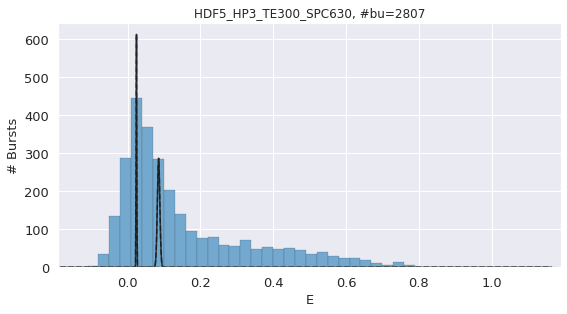

In [96]:
dplot(ds_FRET, hist_fret, show_model=True, pdf=False);

In [97]:
res = E_fitter.fit_res[0]
res.params.pretty_print()
print(res.fit_report(min_correl=0.5))

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
p1_amplitude     1.327     0.01      inf     None     True     None     None
p1_center       0.0243     -0.1      1.1     None     True     None     None
p1_fwhm          0.002     -inf      inf     None    False 2.3548200*p1_sigma     None
p1_height        623.5     -inf      inf     None    False 0.3989423*p1_amplitude/max(2.220446049250313e-16, p1_sigma)     None
p1_sigma      0.0008493        0        1     None     True     None     None
p2_amplitude     2.458     0.01      inf     None     True     None     None
p2_center      0.08524     -0.1      1.1     None     True     None     None
p2_fwhm       0.008054     -inf      inf     None    False 2.3548200*p2_sigma     None
p2_height        286.7     -inf      inf     None    False 0.3989423*p2_amplitude/max(2.220446049250313e-16, p2_sigma)     None
p2_sigma       0.00342        0        1     None     True     None     None
[[Model]]
    (Model(gaussia

In [98]:
ci = res.conf_interval()
lmfit.report_ci(ci)

MinimizerException: Cannot determine Confidence Intervals without sensible uncertainty estimates

### MFD calculations on the corrected ratiometric FRET values

In [99]:
nDexDm_FRET_corr, nDexAm_FRET_corr, nAexAm_FRET_corr, E_FRET_corr, S_FRET_corr = allocate_nanotimes(ds_FRET, tcspc_bin, nt_th_Dex, nt_th_Aex)

# Sanity check to test that the number of array elements for the mean nanotimes and E & S are identical
assert(len(nDexDm_FRET_corr)==len(nDexAm_FRET_corr)==len(nAexAm_FRET_corr)==len(E_FRET_corr)==len(S_FRET_corr))



nDexDm_DO_corr, nDexAm_DO_corr, nAexAm_DO_corr, E_DO_corr, S_DO_corr = allocate_nanotimes(ds_DO, tcspc_bin, nt_th_Dex, nt_th_Aex)

# Sanity check to test that the number of array elements for the mean nanotimes and E & S are identical
assert(len(nDexDm_DO_corr)==len(nDexAm_DO_corr)==len(nAexAm_DO_corr)==len(E_DO_corr)==len(S_DO_corr))

#### Some E vs. tau 2D plots, for several nanotimes of different streams

Text(0.5, 1.0, 'Ratiometric FRET vs. acceptor mean nanotime (Aex.)\nFRET population')

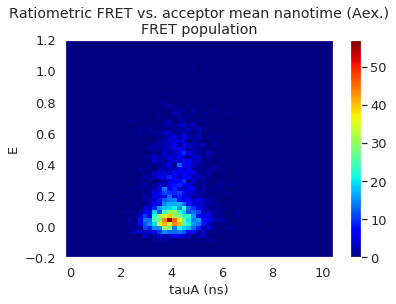

In [100]:
plt.hist2d(nAexAm_FRET_corr, E_FRET_corr, bins=(55,55), range=[[-0.2,10.4],[-0.2,1.2]], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('tauA (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. acceptor mean nanotime (Aex.)\nFRET population')

Text(0.5, 1.0, 'Ratiometric FRET vs. acceptor mean nanotime (Dex.)\nFRET population')

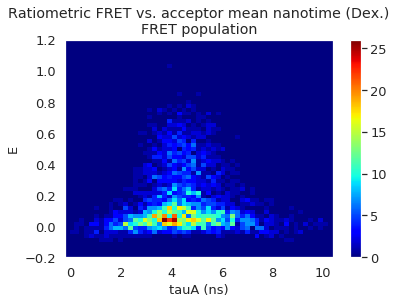

In [101]:
plt.hist2d(nDexAm_FRET_corr, E_FRET_corr, bins=(55,55), range=[[-0.2,10.4],[-0.2,1.2]], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('tauA (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. acceptor mean nanotime (Dex.)\nFRET population')

Text(0.5, 1.0, 'Ratiometric FRET vs. Donor mean nanotime\nFRET population')

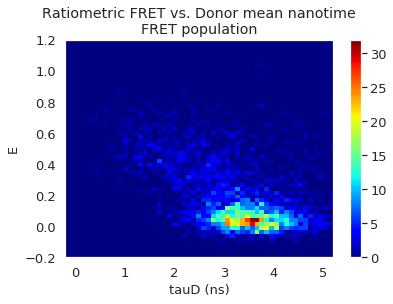

In [102]:
plt.hist2d(nDexDm_FRET_corr, E_FRET_corr, bins=(55,55), range=[[-0.2,5.2],[-0.2,1.2]], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('tauD (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. Donor mean nanotime\nFRET population')

Text(0.5, 1.0, 'Ratiometric FRET vs. Donor mean nanotime\nDO population')

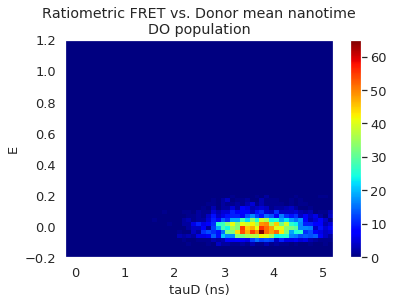

In [103]:
plt.hist2d(nDexDm_DO, E_DO, bins=(55,55), range=[[-0.2,5.2],[-0.2,1.2]], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('tauD (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. Donor mean nanotime\nDO population')

In [104]:
mn_nt_DO = np.mean(nDexDm_DO)
mn_nt_DO

3.7654193995100145

In [105]:
mn_nt_AO = np.mean(nAexAm_FRET_corr)
mn_nt_AO

4.159317284303774

#### Production of FRET lines for MFD plots
Code adapted from Thomas Peulen - https://github.com/Fluorescence-Tools/ChiSurf/blob/master/docs/notebooks/fret_lines.ipynb

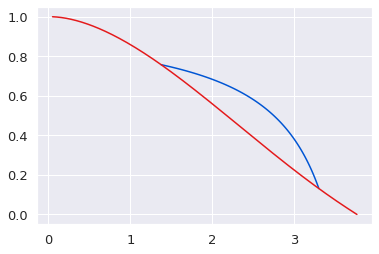

In [106]:
# Definition of normal distribution and Gaussian chain distribution
pdf_norm = lambda x, mean, sigma: np.exp(-(x-mean)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
pdf_mix = lambda x, m1, s1, m2, s2, x1: 0.5 * (x1 * pdf_norm(x, m1, s1) + (1-x1) * pdf_norm(x, m2, s1))

rda2fret = lambda rda, r0: 1./(1+(rda/r0)**6.)
rda2tau = lambda rda, tauD0, r0: (1-rda2fret(rda, r0))*tauD0
tau2taux = lambda x, tau: np.dot(x,tau) / np.sum(x)
fret2avfret = lambda x, fret: np.dot(x, fret) / np.sum(x)
tau2tauf = lambda x, tau: np.dot(x,tau**2) / tau2taux(x,tau) / np.sum(x)

tauD0 = mn_nt_DO
r0 = 65
sigma = 10
rda = np.linspace(0, 250, 250)
fret_efficiency = rda2fret(rda, r0)
tau = rda2tau(rda, tauD0, r0)

# Calculation of a static FRET line
av_fret = list()
tau_f = list()
scan_range = np.linspace(5, 250, 500)
for m_rda in scan_range:
  x = pdf_norm(rda, m_rda, sigma)
  tau_f.append(tau2tauf(x, tau))
  av_fret.append(fret2avfret(x, fret_efficiency))
static_fret = av_fret
static_tau = tau_f

# Calculation of a dynamic FRET line
m1 = 52
m2 = 92
s1 = s2 = sigma
av_fret = list()
tau_f = list()
scan_range = np.linspace(0, 1, 100)
for x1 in scan_range:
  x = pdf_mix(rda, m1, s1, m2, s2, x1)
  tau_f.append(tau2tauf(x, tau))
  av_fret.append(fret2avfret(x, fret_efficiency))
dynamic_fret = av_fret
dynamic_tau = tau_f

plt.plot(dynamic_tau, dynamic_fret)
plt.plot(static_tau, static_fret)
plt.show()

### Donor nanotime MFD plots
#### FRET population

In [107]:
bns = 40

Text(0.5, 1.0, 'Ratiometric FRET vs. Donor mean nanotime\nFRET population')

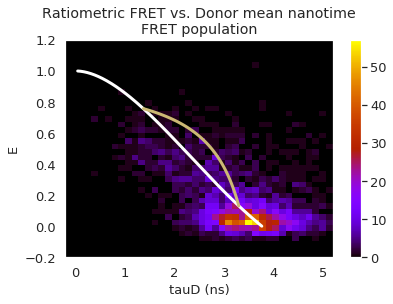

In [108]:
plt.hist2d(nDexDm_FRET_corr, E_FRET_corr, bins=(bns,bns), range=[[-0.2,5.2],[-0.2,1.2]], cmap=plt.cm.gnuplot)
plt.plot(static_tau, static_fret, 'w', linewidth=3)
plt.plot(dynamic_tau, dynamic_fret, 'y', linewidth=3)
plt.colorbar()
plt.xlim(-0.2, 5.2)
plt.ylim(-0.2, 1.2)
plt.xlabel('tauD (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. Donor mean nanotime\nFRET population')

#### DO population

Text(0.5, 1.0, 'Ratiometric FRET vs. Donor mean nanotime\nDO population')

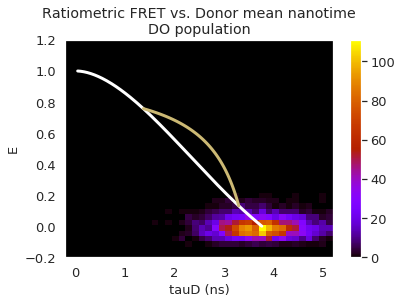

In [109]:
plt.hist2d(nDexDm_DO, E_DO, bins=(bns,bns), range=[[-0.2,5.2],[-0.2,1.2]], cmap=plt.cm.gnuplot)
plt.plot(static_tau, static_fret, 'w', linewidth=3)
plt.plot(dynamic_tau, dynamic_fret, 'y', linewidth=3)
plt.colorbar()
plt.xlim(-0.2, 5.2)
plt.ylim(-0.2, 1.2)
plt.xlabel('tauD (ns)')
plt.ylabel('E')
plt.title('Ratiometric FRET vs. Donor mean nanotime\nDO population')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


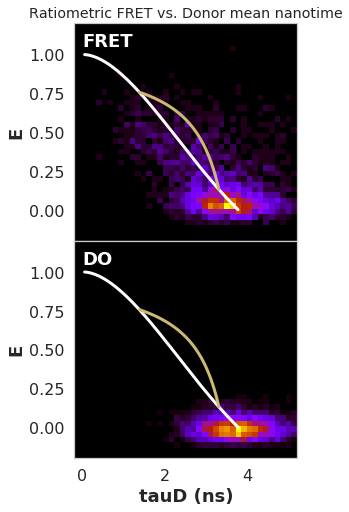

In [110]:
pnlsRows = 2
pnlsCols = 1
sns.set_style(style='whitegrid')
fig, ax = plt.subplots(pnlsRows, pnlsCols, sharex=True, figsize=(4*pnlsCols, 4*pnlsRows))
plt.subplots_adjust(hspace=0, wspace=0.2)

im0 = ax[0].hist2d(nDexDm_FRET_corr, E_FRET_corr, bins=(bns,bns), range=[[-0.2,5.2],[-0.2,1.2]], cmap=plt.cm.gnuplot)
ax[0].plot(static_tau, static_fret, 'w', linewidth=3)
ax[0].plot(dynamic_tau, dynamic_fret, 'y', linewidth=3)
#ax[0].colorbar()
#ax[0].set_xlabel('tauD (ns)')
ax[0].set_title('Ratiometric FRET vs. Donor mean nanotime')#\nFRET population')
ax[0].text(0, 1.05, 'FRET', fontsize=18, fontname='arial', fontweight='bold', color='white')

im1 = ax[1].hist2d(nDexDm_DO, E_DO, bins=(bns,bns), range=[[-0.2,5.2],[-0.2,1.2]], cmap=plt.cm.gnuplot)
ax[1].plot(static_tau, static_fret, 'w', linewidth=3)
ax[1].plot(dynamic_tau, dynamic_fret, 'y', linewidth=3)
#ax[1].colorbar()
ax[1].set_xlabel('tauD (ns)', fontsize=18, fontname='arial', fontweight='bold')
#ax[1].title('Ratiometric FRET vs. Donor mean nanotime\nDO population')
ax[1].text(0, 1.05, 'DO', fontsize=18, fontname='arial', fontweight='bold', color='white')

#ax[0].set_ylim(0,590)
#ax[1].set_ylim(0,0.4)

#ax[0].set_yticks(np.arange(0, 590, 200))
#ax[1].set_yticks(np.arange(0, 0.4, 0.1))

for a in ax.ravel():
    a.set_ylabel('E', fontsize=18, fontname='arial', fontweight='bold')
    a.set_xlim(-0.2, 5.2)
    a.set_ylim(-0.2, 1.2)
    a.tick_params(axis='both', which='major', labelsize=16)
    a.tick_params(axis='both', which='minor', labelsize=14)

fig.set_edgecolor('white')

### Some plots of burst statistics
#### Burst size histograms

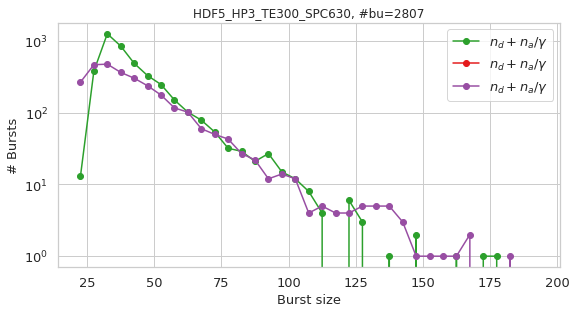

In [111]:
bins=(20, 200, 5)
dplot(ds_DO, hist_size, pdf=False, bins=bins, plot_style={'color': 'C2', });
dplot(ds_AO, hist_size, pdf=False, bins=bins, ax=plt.gca(), plot_style={'color': 'C1', });
dplot(ds_FRET, hist_size, pdf=False, bins=bins, ax=plt.gca(), plot_style={'color': 'C3', });

#### Burst width histograms

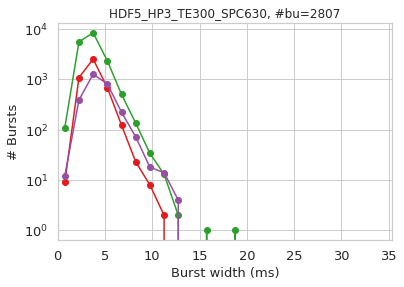

In [112]:
bins=(0, 35, 1.5)
dplot(ds_all, hist_width, pdf=False, bins=bins, ax=plt.gca(), plot_style={'color': 'C2', });
dplot(ds_AO, hist_width, pdf=False, bins=bins, ax=plt.gca(), plot_style={'color': 'C1', });
dplot(ds_FRET, hist_width, pdf=False, bins=bins, ax=plt.gca(), plot_style={'color': 'C3', });


#### Burst peak photon rate histograms

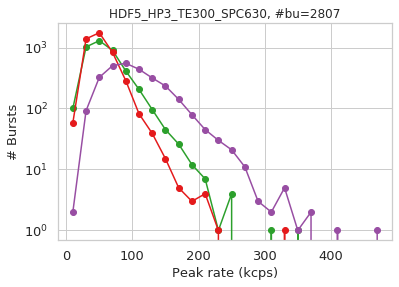

In [113]:
bins=(0, 500, 20)
dplot(ds_DO, hist_burst_phrate, pdf=False, bins=bins, ax=plt.gca(), plot_style={'color': 'C2', });
dplot(ds_AO, hist_burst_phrate, pdf=False, bins=bins, ax=plt.gca(), plot_style={'color': 'C1', });
dplot(ds_FRET, hist_burst_phrate, pdf=False, bins=bins, ax=plt.gca(), plot_style={'color': 'C3', });


##### Burst separation histograms
separation times between consecutive bursts

In [114]:
def burst_separation_hist(ds, logbins_min, logbins_max, logbins_amount, timeunit):
    t_sep = np.logspace(logbins_min, logbins_max, logbins_amount)
    widths = (t_sep[1:] - t_sep[:-1])
    sz = np.size(ds.E[0])
    tmp = ds.mburst[0]
    tmp1 = timeunit * tmp.start
    tmp2 = timeunit * tmp.stop
    burst_sep = []
    for i in range(1, sz):
        burst_sep.append(tmp1[i] - tmp2[i-1])
    
    burst_sep_hist = np.histogram(burst_sep, bins=t_sep)
    plt.semilogx(burst_sep_hist[1][:-1], burst_sep_hist[0], marker='o');
    plt.xlabel('Separation time (s)')
    plt.ylabel('Consecutive Busrts')
    return [burst_sep_hist[1][:-1], burst_sep_hist[0], burst_sep_hist]

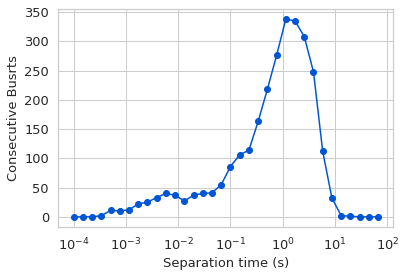

In [115]:
burst_sep_hist_x, burst_sep_hist_y, burst_sep_hist = burst_separation_hist(ds_FRET, -4, 2, 35, 50e-9)

In [116]:
np.size(burst_sep_hist[1][:-1]), np.size(burst_sep_hist[0])

(34, 34)

##### Then, one can select bursts separated by a given time and observe the E histograms of them
Here we chose to show all bursts separated by less than 20 ms, showing the first & second bursts out of each pair

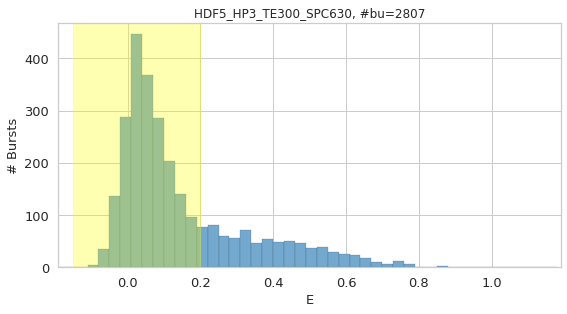

In [117]:
dplot(ds_FRET, hist_fret, pdf=False)
init_E_min = -0.15
init_E_max = 0.2
plt.axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

In [118]:
def burst_separation_test_FRETchanges(ds, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, timeunit):
    Elist_recurrent = []
    Elist_first = []
    ds_FRET_bursts_E = ds.E[0]
    ds_FRET_bursts = ds.mburst[0]
    ds_FRET_bursts_sep = ds_FRET_bursts.separation * timeunit
    sz = len(ds_FRET_bursts_E)
    for i in range (0, sz):
        if i < sz-1:
            if ds_FRET_bursts_E[i] >= init_E_min and ds_FRET_bursts_E[i] <= init_E_max and ds_FRET_bursts_sep[i] > burst_sep_lower_th and ds_FRET_bursts_sep[i] <= burst_sep_upper_th:
                Elist_recurrent.append(ds_FRET_bursts_E[i+1])
        if i < sz-1:
            if ds_FRET_bursts_sep[i] > burst_sep_lower_th and ds_FRET_bursts_sep[i] <= burst_sep_upper_th:
                Elist_first.append(ds_FRET_bursts_E[i])
    return [Elist_first, Elist_recurrent]

In [119]:
burst_sep_lower_th = 0 * 1e-3
burst_sep_upper_th = 1 * 1e-3
init_E_min = -0.15
init_E_max = 0.2

Elist_first_0_1, Elist_recurrent_0_1 = burst_separation_test_FRETchanges(ds_FRET, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, 50e-9)


In [120]:
burst_sep_lower_th = 1 * 1e-3
burst_sep_upper_th = 1 * 1e-2
init_E_min = -0.15
init_E_max = 0.2

Elist_first_1_10, Elist_recurrent_1_10 = burst_separation_test_FRETchanges(ds_FRET, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, 50e-9)


In [121]:
burst_sep_lower_th = 1 * 1e-2
burst_sep_upper_th = 1 * 1e-1
init_E_min = -0.15
init_E_max = 0.2
Elist_recurrent = []
Elist_first = []


Elist_first_10_100, Elist_recurrent_10_100 = burst_separation_test_FRETchanges(ds_FRET, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, 50e-9)


In [122]:
burst_sep_lower_th = 1 * 1e-1
burst_sep_upper_th = 1 * 1e-0
init_E_min = -0.15
init_E_max = 0.2
Elist_recurrent = []
Elist_first = []


Elist_first_100_1000, Elist_recurrent_100_1000 = burst_separation_test_FRETchanges(ds_FRET, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, 50e-9)


In [123]:
burst_sep_lower_th = 1 * 1e0
burst_sep_upper_th = 1 * 1e1
init_E_min = -0.15
init_E_max = 0.2
Elist_recurrent = []
Elist_first = []


Elist_first_1000_10000, Elist_recurrent_1000_10000 = burst_separation_test_FRETchanges(ds_FRET, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, 50e-9)


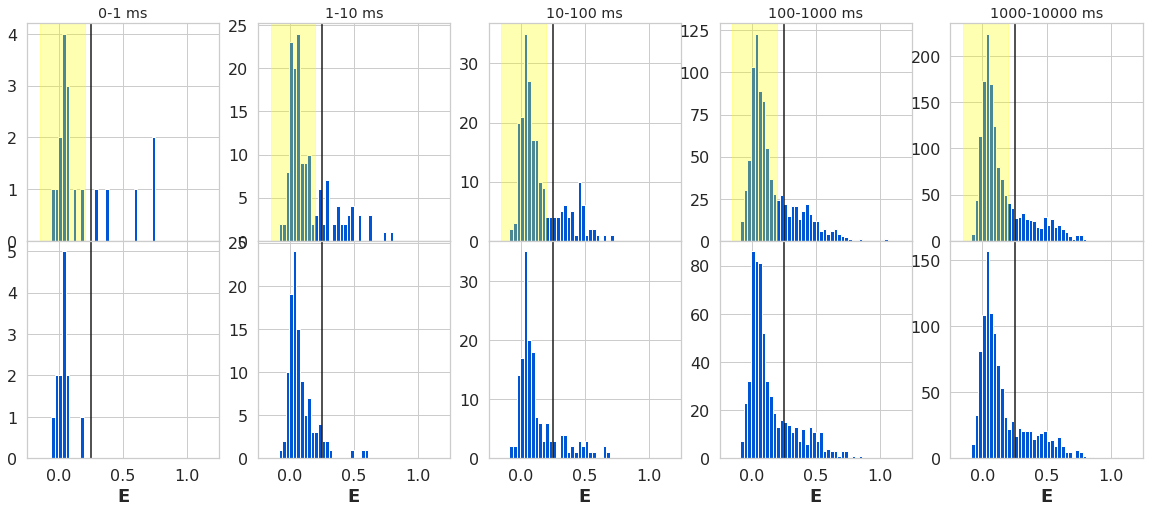

In [124]:
pnlsRows = 2
pnlsCols = 5
sns.set_style(style='whitegrid')
fig, ax = plt.subplots(pnlsRows, pnlsCols, sharex=True, figsize=(4*pnlsCols, 4*pnlsRows))
plt.subplots_adjust(hspace=0, wspace=0.2)

ax[0,0].hist(Elist_first_0_1, 50, range=(-0.2,1.2));
ax[1,0].hist(Elist_recurrent_0_1, 50, range=(-0.2,1.2));
ax[0,0].set_title('0-1 ms')
ax[1,0].set_title('')
ax[1,0].set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
ax[0,0].axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

ax[0,1].hist(Elist_first_1_10, 50, range=(-0.2,1.2));
ax[1,1].hist(Elist_recurrent_1_10, 50, range=(-0.2,1.2));
ax[0,1].set_title('1-10 ms')
ax[1,1].set_title('')
ax[1,1].set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
ax[0,1].axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

ax[0,2].hist(Elist_first_10_100, 50, range=(-0.2,1.2));
ax[1,2].hist(Elist_recurrent_10_100, 50, range=(-0.2,1.2));
ax[0,2].set_title('10-100 ms')
ax[1,2].set_title('')
ax[1,2].set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
ax[0,2].axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

ax[0,3].hist(Elist_first_100_1000, 50, range=(-0.2,1.2));
ax[1,3].hist(Elist_recurrent_100_1000, 50, range=(-0.2,1.2));
ax[0,3].set_title('100-1000 ms')
ax[1,3].set_title('')
ax[1,3].set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
ax[0,3].axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

ax[0,4].hist(Elist_first_1000_10000, 50, range=(-0.2,1.2));
ax[1,4].hist(Elist_recurrent_1000_10000, 50, range=(-0.2,1.2));
ax[0,4].set_title('1000-10000 ms')
ax[1,4].set_title('')
ax[1,4].set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
ax[0,4].axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

for a in ax.ravel():
    a.set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
    a.set_xlim(-0.25, 1.25)
    a.tick_params(axis='both', which='major', labelsize=16)
    a.tick_params(axis='both', which='minor', labelsize=14)
    a.axvline(x=0.25, color='k')


##### ... and then for another range of FRET values

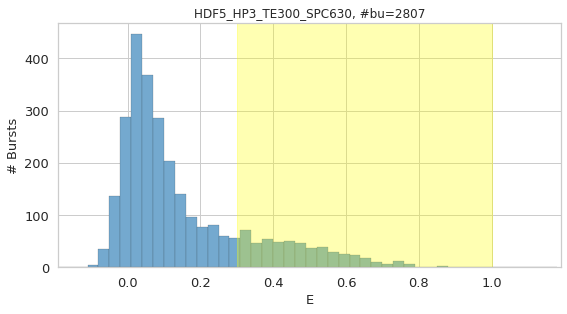

In [125]:
dplot(ds_FRET, hist_fret, pdf=False)
init_E_min = 0.3
init_E_max = 1.0
plt.axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

In [126]:
burst_sep_lower_th = 0 * 1e-3
burst_sep_upper_th = 1 * 1e-3
init_E_min = 0.3
init_E_max = 1.0
Elist_recurrent = []
Elist_first = []

Elist_first_0_1, Elist_recurrent_0_1 = burst_separation_test_FRETchanges(ds_FRET, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, 50e-9)


In [127]:
burst_sep_lower_th = 1 * 1e-3
burst_sep_upper_th = 1 * 1e-2
init_E_min = 0.3
init_E_max = 1.0
Elist_recurrent = []
Elist_first = []

Elist_first_1_10, Elist_recurrent_1_10 = burst_separation_test_FRETchanges(ds_FRET, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, 50e-9)


In [128]:
burst_sep_lower_th = 1 * 1e-2
burst_sep_upper_th = 1 * 1e-1
init_E_min = 0.3
init_E_max = 1.0
Elist_recurrent = []
Elist_first = []

Elist_first_10_100, Elist_recurrent_10_100 = burst_separation_test_FRETchanges(ds_FRET, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, 50e-9)


In [129]:
burst_sep_lower_th = 1 * 1e-1
burst_sep_upper_th = 1 * 1e-0
init_E_min = 0.3
init_E_max = 1.0
Elist_recurrent = []
Elist_first = []

Elist_first_100_1000, Elist_recurrent_100_1000 = burst_separation_test_FRETchanges(ds_FRET, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, 50e-9)


In [130]:
burst_sep_lower_th = 1 * 1e0
burst_sep_upper_th = 1 * 1e1
init_E_min = 0.3
init_E_max = 1.0
Elist_recurrent = []
Elist_first = []

Elist_first_1000_10000, Elist_recurrent_1000_10000 = burst_separation_test_FRETchanges(ds_FRET, burst_sep_lower_th, burst_sep_upper_th, init_E_min, init_E_max, 50e-9)


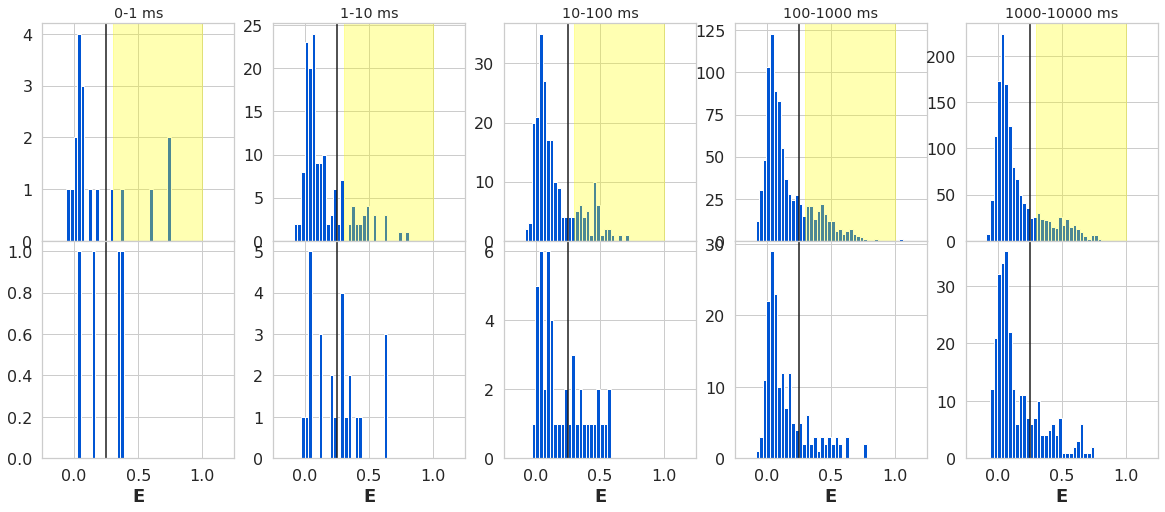

In [131]:
pnlsRows = 2
pnlsCols = 5
sns.set_style(style='whitegrid')
fig, ax = plt.subplots(pnlsRows, pnlsCols, sharex=True, figsize=(4*pnlsCols, 4*pnlsRows))
plt.subplots_adjust(hspace=0, wspace=0.2)

ax[0,0].hist(Elist_first_0_1, 50, range=(-0.2,1.2));
ax[1,0].hist(Elist_recurrent_0_1, 50, range=(-0.2,1.2));
ax[0,0].set_title('0-1 ms')
ax[1,0].set_title('')
ax[1,0].set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
ax[0,0].axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

ax[0,1].hist(Elist_first_1_10, 50, range=(-0.2,1.2));
ax[1,1].hist(Elist_recurrent_1_10, 50, range=(-0.2,1.2));
ax[0,1].set_title('1-10 ms')
ax[1,1].set_title('')
ax[1,1].set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
ax[0,1].axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

ax[0,2].hist(Elist_first_10_100, 50, range=(-0.2,1.2));
ax[1,2].hist(Elist_recurrent_10_100, 50, range=(-0.2,1.2));
ax[0,2].set_title('10-100 ms')
ax[1,2].set_title('')
ax[1,2].set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
ax[0,2].axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

ax[0,3].hist(Elist_first_100_1000, 50, range=(-0.2,1.2));
ax[1,3].hist(Elist_recurrent_100_1000, 50, range=(-0.2,1.2));
ax[0,3].set_title('100-1000 ms')
ax[1,3].set_title('')
ax[1,3].set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
ax[0,3].axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

ax[0,4].hist(Elist_first_1000_10000, 50, range=(-0.2,1.2));
ax[1,4].hist(Elist_recurrent_1000_10000, 50, range=(-0.2,1.2));
ax[0,4].set_title('1000-10000 ms')
ax[1,4].set_title('')
ax[1,4].set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
ax[0,4].axvspan(init_E_min, init_E_max, alpha=0.3, color='yellow')

for a in ax.ravel():
    a.set_xlabel('E', fontsize=18, fontname='arial', fontweight='bold')
    a.set_xlim(-0.25, 1.25)
    a.tick_params(axis='both', which='major', labelsize=16)
    a.tick_params(axis='both', which='minor', labelsize=14)
    a.axvline(x=0.25, color='k')


## FCS

In [132]:
import pycorrelate as pyc
pyc.__version__

'0.3'

Model for fitting the FCS curves, to retrieve the diffusion time, tauD, the mean number of molecules in the efective detection volume, N, and posibly also additional microsecond dynamics (triplet blinking or FRET dynamics)

In [133]:
def FCS_3D_diff(x, tauD, N, kappa):
    return ((1/N) * 1/(1 + x/tauD) * 1/np.sqrt(1 + (1/kappa)**2 * x/tauD))
def FCS_3D_diff_triplet(x, tauD, N, kappa, T, tauT):
    return ((1/N) * (1 + T * np.exp(-x / tauT))/(1 + x/tauD) * 1/np.sqrt(1 + (1/kappa)**2 * x/tauD))
def FCS_3D_diff_FRETdyn(x, tauD, N, kappa, C, tauC):
    return ((1/N) * (1 - C * np.exp(-x / tauC))/(1 + x/tauD) * 1/np.sqrt(1 + (1/kappa)**2 * x/tauD))

# The difference between triplet dynamics & FRET dynamics is that triplet blinking dynamics is positively correlated 
# (hence the + sign in the additional exponential term) & FRET dynamics is negatively correlated 
# in the donor-acceptor cross-corrlelation

In [134]:
# compute lags in sec. then convert to timestamp units
hw_unit = 200e-9
bins_per_dec = 5
bins = np.unique(np.round(pyc.make_loglags(-1, 10, bins_per_dec)).astype('int')) 
timelags_exp = bins[1:] * hw_unit
print(f'Min time-lag: {timelags_exp[0]},  Max time-lag: {timelags_exp[-1]},  # Time-lags: {len(timelags_exp)}')

Min time-lag: 2e-07,  Max time-lag: 2000.0,  # Time-lags: 51


### FCS of photons in FRET bursts

In [135]:
# Photon times of donor & acceptor channels of the FRET population
burstphFRET_D = ds_FRET.get_ph_times(ph_sel=Ph_sel(Dex='Dem'))
burstphFRET_A = ds_FRET.get_ph_times(ph_sel=Ph_sel(Dex='Aem'))

In [136]:
# Donor auto-correlation
AC_FRET_D = pyc.pcorrelate(burstphFRET_D, burstphFRET_D, bins, normalize=True)-1
# Acceptor auto-correlation
AC_FRET_A = pyc.pcorrelate(burstphFRET_A, burstphFRET_A, bins, normalize=True)-1
# Donor-Acceptor cross-correlation
CC_FRET = pyc.pcorrelate(burstphFRET_D, burstphFRET_A, bins, normalize=True)-1

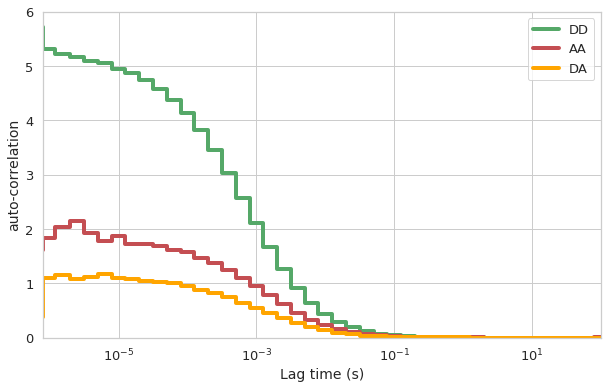

In [137]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_exp, AC_FRET_D, drawstyle='steps-pre', linewidth=4, color='g', label='DD')
plt.semilogx(timelags_exp, AC_FRET_A, drawstyle='steps-pre', linewidth=4, color='r', label='AA')
plt.semilogx(timelags_exp, CC_FRET, drawstyle='steps-pre', linewidth=4, color='orange', label='DA')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(8e-7, 100)
plt.ylim(0, 6);
plt.ylabel('auto-correlation', fontsize=14)
plt.xlabel('Lag time (s)', fontsize=14)
plt.legend()

 One can see the auto-correlation of the signal from the same SPAD includes a large contribution from afterpulsing.
 This contribution is not included in the cross-correlation of the signal from two independent detectors

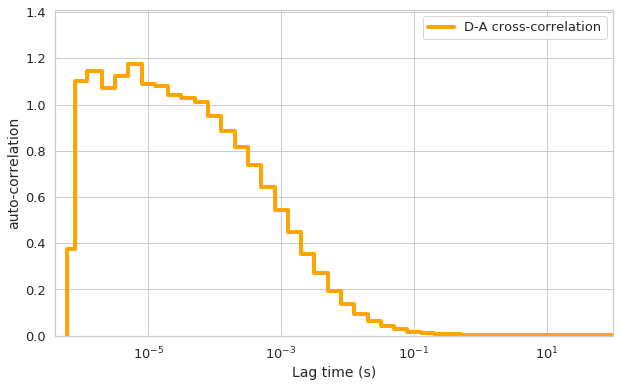

In [138]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.semilogx(timelags_exp, CC_FRET, drawstyle='steps-pre', linewidth=4, color='orange', label='D-A cross-correlation')
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(4e-7, 100)
plt.ylim(0, np.max(CC_FRET) * 1.2);
plt.ylabel('auto-correlation', fontsize=14)
plt.xlabel('Lag time (s)', fontsize=14)
plt.legend()

#### Fitting the donor-acceptor cross-correlation curve
##### to a 3D diffusion model

In [139]:
# We chose to use the 3D diffusion
from lmfit import Model
gmodel = Model(FCS_3D_diff)

In [140]:
# Model parameter value initialization bfore fitting
gmodel.set_param_hint('tauD', value=1e-3, min=0, max=np.inf)
gmodel.set_param_hint('N', value=1/0.25, min=0, max=np.inf)
gmodel.set_param_hint('kappa', value=10, min=9.9, max=10.1)
params = gmodel.make_params()

In [141]:
# Fitting of FCS model to data
result_3D = gmodel.fit(CC_FRET[7:48], params, x=timelags_exp[7:48])

In [142]:
result_3D.chisqr, result_3D.redchi

(0.03459293181664363, 0.000910340310964306)

In [143]:
# Did the fit converge?
result_3D.success

True

In [144]:
# Best fit values + fitting statistics
print(result_3D.fit_report())

[[Model]]
    Model(FCS_3D_diff)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6724
    # data points      = 41
    # variables        = 3
    chi-square         = 0.03459293
    reduced chi-square = 9.1034e-04
    Akaike info crit   = -284.184797
    Bayesian info crit = -279.044080
[[Variables]]
    tauD:   0.00131054 +/- 1.0455e-04 (7.98%) (init = 0.001)
    N:      0.92268870 +/- 0.00980388 (1.06%) (init = 4)
    kappa:  10.1000000 +/- 14.2524998 (141.11%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(tauD, kappa) =  0.720
    C(tauD, N)     =  0.533
    C(N, kappa)    =  0.220


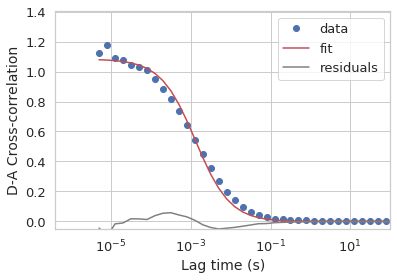

In [145]:
plt.semilogx(timelags_exp[7:48], CC_FRET[7:48], 'bo', label='data')
plt.semilogx(timelags_exp[7:48], result_3D.best_fit, 'r-', label='fit')
plt.semilogx(timelags_exp[7:48], result_3D.residual, 'grey', label='residuals')
plt.ylabel('D-A Cross-correlation', fontsize=14)
plt.xlabel('Lag time (s)', fontsize=14)

plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(4e-7, 100)
plt.ylim(-0.05, np.max(result_3D.best_fit)*1.3);

plt.legend()
plt.show()

CC_FRET_fit = result_3D.best_fit

Fit was not that good. Moving on to fitting the data to a more detailed model

##### Fitting the donor-acceptor cross-correlation curve to a 3D diffusion + triplet blinking model

In [146]:
# We chose to use the 3D diffusion + triplet blinking model, since it best describes the D-A cross-correlation in this case
# That is after trying with a 3D diffusion only model and failing to get a good fit
from lmfit import Model
gmodel = Model(FCS_3D_diff_FRETdyn)

In [147]:
# Model parameter value initialization bfore fitting
gmodel.set_param_hint('tauD', value=1e-3, min=0, max=np.inf)
gmodel.set_param_hint('N', value=1/0.25, min=0, max=np.inf)
gmodel.set_param_hint('kappa', value=10, min=9.9, max=10.1)
gmodel.set_param_hint('tauC', value=1e-3, min=0, max=np.inf)
gmodel.set_param_hint('C', value=0.4, min=0, max=np.inf)
params = gmodel.make_params()

In [148]:
# Fitting of FCS model to data
result_3Dtrip = gmodel.fit(CC_FRET[7:48], params, x=timelags_exp[7:48])

In [149]:
result_3Dtrip.chisqr, result_3Dtrip.redchi

(0.03459232085506458, 0.0009608978015295716)

In [150]:
# Did the fit converge?
result_3Dtrip.success

True

In [151]:
# Best fit values + fitting statistics
print(result_3Dtrip.fit_report())

[[Model]]
    Model(FCS_3D_diff_FRETdyn)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5318
    # data points      = 41
    # variables        = 5
    chi-square         = 0.03459232
    reduced chi-square = 9.6090e-04
    Akaike info crit   = -280.185521
    Bayesian info crit = -271.617660
[[Variables]]
    tauD:   0.00131161 +/- 1.0983e-04 (8.37%) (init = 0.001)
    N:      0.92278698 +/- 0.01086591 (1.18%) (init = 4)
    kappa:  10.1000000 +/- 0.00528382 (0.05%) (init = 10)
    C:      0.02573383 +/- 1.1477e+12 (4459833453900563.50%) (init = 0.4)
    tauC:   3.9157e-07 +/- 1430417.67 (365305272788204.50%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, tauC)     = -1.000
    C(tauD, kappa) =  0.720
    C(tauD, N)     =  0.560
    C(N, kappa)    =  0.235


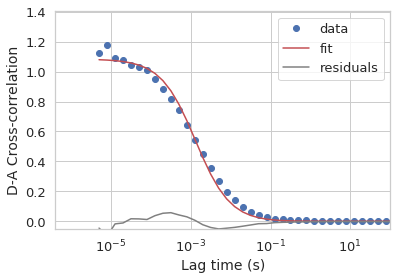

In [152]:
plt.semilogx(timelags_exp[7:48], CC_FRET[7:48], 'bo', label='data')
plt.semilogx(timelags_exp[7:48], result_3Dtrip.best_fit, 'r-', label='fit')
plt.semilogx(timelags_exp[7:48], result_3Dtrip.residual, 'grey', label='residuals')
plt.ylabel('D-A Cross-correlation', fontsize=14)
plt.xlabel('Lag time (s)', fontsize=14)

plt.grid(True); plt.grid(True, which='minor', lw=0.3);
plt.xlim(4e-7, 100)
plt.ylim(-0.05, np.max(result_3Dtrip.best_fit)*1.3);

plt.legend()
plt.show()

CC_FRET_fit = result_3Dtrip.best_fit

##### Comparison of fitting statistics

In [153]:
result_3D.aic, result_3Dtrip.aic

(-284.1847966571391, -280.1855207832722)

In [154]:
# the difference in the AIC values for the two fits
AICdiff = result_3Dtrip.aic - result_3D.aic
AICdiff

3.9992758738669067

In [155]:
relLikelihood = np.exp(AICdiff/2)
relLikelihood

7.386381278876582

## FRET-2CDE
Adapted based on the work of Tomov et al. 2012 (doi: 10.1016/j.bpj.2011.11.4025).

In [156]:
from fretbursts_dev.phtools import phrates

In [157]:
def calc_fret_2cde(tau, ph, mask_d, mask_a, bursts):
    """
    Compute FRET-2CDE for each burst.

    FRET-2CDE is a quantity that tends to be around 10 for bursts which have no
    dynamics, while it has larger values (e.g. 30..100) for bursts with
    millisecond dynamics.

    References:
        Tomov et al. BJ (2012) doi:10.1016/j.bpj.2011.11.4025

    Arguments:
        tau (scalar): time-constant of the exponential KDE
        ph (1D array): array of all-photons timestamps.
        mask_d (bool array): mask for DexDem photons
        mask_a (bool array): mask for DexAem photons
        bursts (Bursts object): object containing burst data
            (start-stop indexes are relative to `ph`).

    Returns:
        FRET_2CDE (1D array): array of FRET_2CDE quantities, one element
            per burst. This array contains NaN in correspondence of bursts
            containing to few photons to compute FRET-2CDE.
    """
    # Computing KDE burst-by-burst would cause inaccuracies at the burst edges.
    # Therefore, we first compute KDE on the full timestamps array and then
    # we take slices for each burst.
    # These KDEs are evaluated on all-photons array `ph` (hence the Ti suffix)
    # using D or A photons during D-excitation (argument ph[mask_d] or ph[mask_a]).
    KDE_DTi = phrates.kde_laplace(ph[mask_d], tau, time_axis=ph)
    KDE_ATi = phrates.kde_laplace(ph[mask_a], tau, time_axis=ph)

    FRET_2CDE = []
    for ib, burst in enumerate(bursts):
        burst_slice = slice(int(burst.istart), int(burst.istop) + 1)
        if ~mask_d[burst_slice].any() or ~mask_a[burst_slice].any():
            # Either D or A photon stream has no photons in current burst,
            # thus FRET_2CDE cannot be computed. Fill position with NaN.
            FRET_2CDE.append(np.nan)
            continue

        # Take slices of KDEs for current burst
        kde_adi = KDE_ATi[burst_slice][mask_d[burst_slice]]
        kde_ddi = KDE_DTi[burst_slice][mask_d[burst_slice]]
        kde_dai = KDE_DTi[burst_slice][mask_a[burst_slice]]
        kde_aai = KDE_ATi[burst_slice][mask_a[burst_slice]]

        # nbKDE does not include the "center" timestamp which contributes 1.
        # We thus subtract 1 from the precomputed KDEs.
        # The N_CHD (N_CHA) value in the correction factor is the number of
        # timestamps in DexDem (DexAem) stream falling within the current burst.
        N_CHD = mask_d[burst_slice].sum()
        N_CHA = mask_a[burst_slice].sum()
        nbkde_ddi = (1 + 2/N_CHD) * (kde_ddi - 1)
        nbkde_aai = (1 + 2/N_CHA) * (kde_aai - 1)

        # N_CHD (N_CHA) in eq. 6 (eq. 7) of (Tomov 2012) is the number of photons
        # in DexDem (DexAem) in current burst. Thus the sum is a mean.
        ED = np.mean(kde_adi / (kde_adi + nbkde_ddi))  # (E)_D
        EA = np.mean(kde_dai / (kde_dai + nbkde_aai))  # (1 - E)_A

        # Compute fret_2cde for current burst
        fret_2cde = 110 - 100 * (ED + EA)
        FRET_2CDE.append(fret_2cde)
    return np.array(FRET_2CDE)

In [158]:
tau_s = 50e-6             # in seconds
tau = int(tau_s/ds_FRET.clk_p)  # in raw timestamp units
tau

1000

In [159]:
ph = ds_FRET.get_ph_times(ph_sel=Ph_sel('all'))
mask_d = ds_FRET.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))
mask_a = ds_FRET.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))

bursts = ds_FRET.mburst[0]

In [160]:
fret_2cde = calc_fret_2cde(tau, ph, mask_d, mask_a, bursts)

<ipython-input-157-a41be04f89b5>:60: RuntimeWarning: invalid value encountered in true_divide
  EA = np.mean(kde_dai / (kde_dai + nbkde_aai))  # (1 - E)_A
<ipython-input-157-a41be04f89b5>:59: RuntimeWarning: invalid value encountered in true_divide
  ED = np.mean(kde_adi / (kde_adi + nbkde_ddi))  # (E)_D


In [161]:
len(fret_2cde), bursts.num_bursts, ds_FRET.num_bursts

(2807, 2807, array([2807]))

Text(0.95, 0.95, '# Bursts: 564')

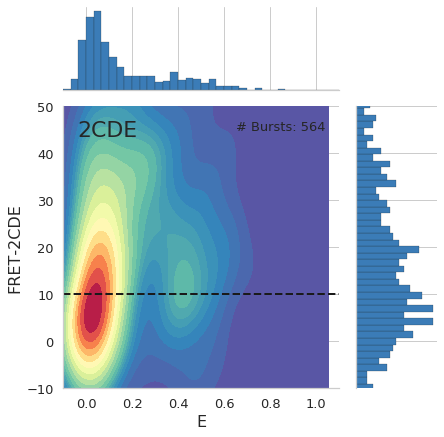

In [162]:
valid = np.isfinite(fret_2cde)
x, y = ds_FRET.E[0][valid], fret_2cde[valid]
hist_kws = dict(edgecolor='k', linewidth=0.2,
                facecolor=sns.color_palette('Spectral_r', 100)[7])

g = sns.JointGrid(x=x, y=y, ratio=3)
g.plot_joint(sns.kdeplot, cmap='Spectral_r', shade=True, thresh=False, n_levels=20)
g.ax_marg_x.hist(x, bins=np.arange(-0.2, 1.2, 0.0333), **hist_kws)
g.ax_marg_y.hist(y, bins=70, orientation="horizontal", **hist_kws)

g.ax_joint.set_xlabel('E', fontsize=16)
g.ax_joint.set_ylabel('FRET-2CDE', fontsize=16);
g.ax_joint.set_ylim(-10, 50);
g.ax_joint.set_xlim(-0.1, 1.1);
g.ax_joint.axhline(10, ls='--', lw=2, color='k')
g.ax_joint.text(0.05, 0.95, '2CDE', va='top', fontsize=22, transform=g.ax_joint.transAxes)
g.ax_joint.text(0.95, 0.95, '# Bursts: %d' % valid.sum(), 
                va='top', ha='right', transform=g.ax_joint.transAxes)
#plt.savefig('2cde_joint.png', bbox_inches='tight', dpi=200, transparent=False)

# BVA
### BVA analysis is run on photons of bursts following ACBS, with no corrections applied

#### We run BVA analysis to make sure the FRET population we have are static. If they are time averages of faster occurring dynamics, their mean FRET efficiency is irrelevant for the per-population Gamma factor calculation

In [163]:
def BVA(d, m, F, th_Aex, th_Dex, n, R, B_Thr):
    d.burst_search(m=m, F=F, ph_sel=Ph_sel(Dex='DAem'), computefret=False)
    d.calc_fret(count_ph=True, corrections=False)
    d.fuse_bursts(ms=0)
    ds1 = Sel(d, select_bursts.naa, th1=th_Aex)
    ds1 = Sel(ds1, select_bursts.size, th1=th_Dex)
    
    bursts =ds1.mburst[0]
    ph_d = ds1.get_ph_times(ph_sel=Ph_sel(Dex='DAem'))
    AemDex_mask = ds1.get_ph_mask(ph_sel=Ph_sel(Dex='Aem')) 
    Dex_mask = ds1.get_ph_mask(ph_sel=Ph_sel(Dex='DAem'))   
    AemDex_mask_d = AemDex_mask[Dex_mask]
    
    bursts_d = bursts.recompute_index_reduce(ph_d)
    
    Std_small=[]
    Avg_small=[]
    for burst in bursts_d:
        E_small=[]
        startlist = range(burst.istart, burst.istop + 2 - n, n)
        stoplist = [i + n for i in startlist]
        for start, stop in zip(startlist, stoplist):
            A_D = AemDex_mask_d[start:stop].sum()
            assert stop-start == n
            E = A_D / n
            E_small.append(E)
        Std_small.append(np.std(E_small))
        Avg_small.append(np.average(E_small))
    
    E_small_num=[]
    E_list_num=[]
    bn=np.arange(0,1+(2/R),1/R)
    Std_small1=[]
    for b1, b2 in zip(bn[:-1], bn[1:]):
        E_small1=[]
        E_list=[]
        for burst in bursts_d:
            A_D = AemDex_mask_d[burst.istart:burst.istop+1].sum()
            E_calc = A_D/burst.counts
            if E_calc >= b1 and E_calc < b2:
                E_list.append(E_calc)
                startlist = range(burst.istart, burst.istop + 2 - n, n)
                stoplist = [i + n for i in startlist]
                for start, stop in zip(startlist, stoplist):
                    for start, stop in zip(startlist, stoplist):
                        assert stop-start == n
                        E = A_D / n
                        E_small1.append(E)
        if np.array(E_list).shape[0] >= B_Thr:
            Std_small1.append(np.std(E_small1))
        else:
            Std_small1.append(-1)
    return (Std_small, Avg_small, Std_small1, bn)

In [164]:
th = 30
R = 20
n = 5
B_Thr = 40
Std_small, Avg_small, Std_small1, bn = BVA(d, 10, 6, th, th, n, R, B_Thr)

 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 12893 bursts (15.6%, 8 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A and FRET]
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


Text(0, 0.5, '$\\sigma_{E^*}$')

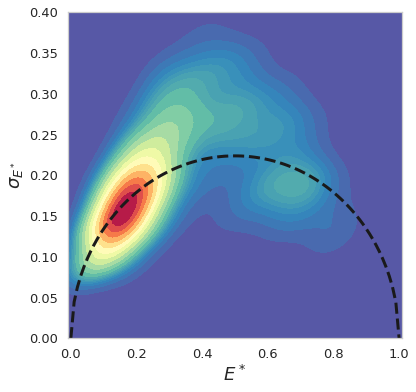

In [179]:
# sns.set_style(style='darkgrid')
x_bin = bn[:-1]+1/(2*R)
plt.figure(figsize=(6,6))
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
plt.plot(x_T,y_T, lw=3, color='k', ls='--')
im = sns.kdeplot(x=np.array(Avg_small), y=np.array(Std_small), shade=True, cmap='Spectral_r', n_levels=20, thresh=False, gridsize=100)
plt.plot (x_bin ,np.array(Std_small1), marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
plt.xlim(-0.01,1.01)
plt.ylim(0,0.4)
plt.xlabel('$E^*$', fontsize=18)
plt.ylabel(r'$\sigma_{E^*}$', fontsize=18)

#plt.savefig(full_fname , dpi=200, bbox_inches='tight')

In [174]:
d.burst_search(m=10, F=6, ph_sel=Ph_sel(Dex='DAem'))
d.fuse_bursts(ms=0)
d.leakage = 0
d.dir_ex = 0
d.gamma = 1
d.beta = 1
ds1 = Sel(d, select_bursts.naa, th1=th, gamma = 1, beta = 1)
ds1 = Sel(ds1, select_bursts.size, th1=th, gamma = 1, beta = 1)

 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 12893 bursts (15.6%, 8 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A and FRET]
   - Applying background correction.
   - Applying direct excitation correction.
   - Applying background correction.


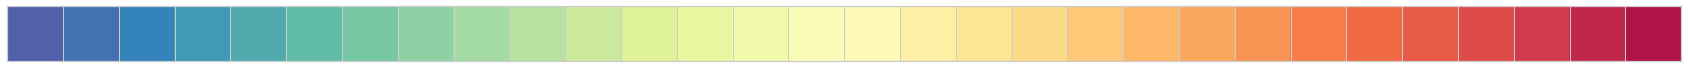

In [181]:
sns.palplot(sns.color_palette('Spectral_r', 30))
BLUE = sns.color_palette('Spectral_r', 30)[0]

Text(0.5, 0, 'PR')

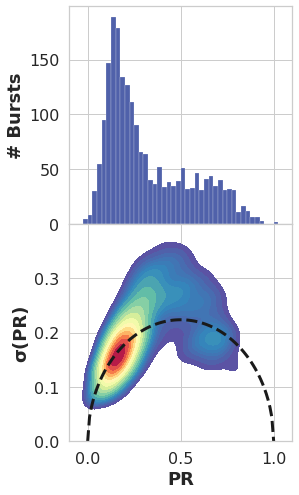

In [184]:
hist_bar_style={'facecolor': BLUE, 'alpha': 1, 'edgecolor': 'white', 'linewidth':0.2}

pnlsRows = 2
pnlsCols = 1
sns.set_style(style='whitegrid')
fig, ax = plt.subplots(pnlsRows, pnlsCols, sharex=True, figsize=(4*pnlsCols, 4*pnlsRows))
plt.subplots_adjust(hspace=0, wspace=0.2)

dplot(ds1, hist_fret, pdf=False, weights = None, ax=ax[0], binwidth=0.025, hist_bar_style=hist_bar_style)


x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
ax[1].plot(x_T,y_T, lw=3, color='k', ls='--')

im = sns.kdeplot(x=np.array(Avg_small), y=np.array(Std_small), shade=True, cmap='Spectral_r', n_levels=20, thresh=0.1, gridsize=100, ax=ax[1])
ax[1].plot (x_bin ,np.array(Std_small1), marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)


#ax[0,0].set_title('(-15)TA-(+2)NTD', fontsize=18, fontname='arial', fontweight='bold')
#ax[0,1].set_title('(-3)TA-(-6)NTD', fontsize=18, fontname='arial', fontweight='bold')
#ax[0,2].set_title('(-8)TA-(-6)NTD', fontsize=18, fontname='arial', fontweight='bold')


#ax[0].set_ylim(0,590)
ax[1].set_ylim(0,0.4)

#ax[0].set_yticks(np.arange(0, 590, 200))
ax[1].set_yticks(np.arange(0, 0.4, 0.1))

for a in ax.ravel():
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_title('')
    a.set_xlim(-0.1,1.1)
    a.tick_params(axis='both', which='major', labelsize=16)
    a.tick_params(axis='both', which='minor', labelsize=14)

ax[0].set_ylabel('# Bursts', fontsize=18, fontname='arial', fontweight='bold')
ax[1].set_ylabel('σ(PR)', fontsize=18, fontname='arial', fontweight='bold')
ax[1].set_xlabel('PR', fontsize=18, fontname='arial', fontweight='bold')



##### The FRET population is...

# Performing H2MM

In [ ]:
def data_sort(data,nchan=2,**kwargs):
    if (len(kwargs) == 0):
        chan_sel = [Ph_sel(Dex='Dem'), Ph_sel(Dex='Aem'), Ph_sel(Aex='Aem'), Ph_sel(Aex='Dem')]
        n = 4
    else:
        n = 1
        chan_sel = []
        while kwargs.get('ph_sel' + str(n)) != None:
            chan_sel.append(kwargs.get('ph_sel' + str(n)))
            n += 1
        n += -1
    print('Sorting photon channels')
    mask = np.array([data.get_ph_mask(ph_sel=chan_sel[i]) for i in range(0,n)])
    if np.any(mask.sum(axis=0) > 1):
        print('Photon assigned to multiple channels, check ph_sel selections')
        return None
    ph_times = data.ph_times_m[0]
    ph_nanotime = data.nanotimes[0]
    nphot = ph_times.shape
    ph_chan = np.array([i*mask[i,:] for i in range(0, n)]).sum(axis=0)
    burst = data.mburst[0]
    ArrivalColor = []
    ArrivalTime = []
    ArrivalNanotime = []
    print('Slicing data into bursts')
    ph_mask = ph_chan < nchan
    phot = 0
    for start, stop in zip(burst.istart, burst.istop + 1):
        ph_mask_temp = np.zeros(nphot,dtype=bool)
        ph_mask_temp[start:stop] = ph_mask[start:stop]
        ArrivalColor.append(ph_chan[ph_mask_temp])
        ArrivalTime.append(ph_times[ph_mask_temp])
        ArrivalNanotime.append(ph_nanotime[ph_mask_temp])
        phot += ph_mask_temp.sum()
    return ArrivalColor, ArrivalTime, ArrivalNanotime, phot

To save time, we load the results from a previous H2MM fitting on the same data, for other data sets, commented lines contain starting H2MM models

In [ ]:
with h5py.File('/home/paul/Python/HDF5/H2MM-DecayFitting-Multichannelresults.hdf5','r') as f:
    obs22i = np.array(f['2state_2det_obs'])
    trans22i = np.array(f['2state_2det_trans'])
    prior22i = np.array(f['2state_2det_prior'])
    obs32i = np.array(f['3state_2det_obs'])
    trans32i = np.array(f['3state_2det_trans'])
    prior32i = np.array(f['3state_2det_prior'])
    obs42i = np.array(f['4state_2det_obs'])
    trans42i = np.array(f['4state_2det_trans'])
    prior42i = np.array(f['4state_2det.prior'])
    obs23i = np.array(f['2state_3det_obs'])
    trans23i = np.array(f['2state_3det_trans'])
    prior23i = np.array(f['2state_3det_prior'])
    obs33i = np.array(f['3state_3det_obs'])
    trans33i = np.array(f['3state_3det_trans'])
    prior33i = np.array(f['3state_3det_prior'])
    obs43i = np.array(f['4state_3det_obs'])
    trans43i = np.array(f['4state_3det_trans'])
    prior43i = np.array(f['4state_3det_prior'])    

In [ ]:
prior12i = np.array([1])
trans12i = np.array([[1]])
obs12i = np.array([[0.5, 0.5]])
prior13i = np.array([1])
trans13i = np.array([[1]])
obs13i = np.array([[0.5, 0.1, 0.4]])
h_mod12i = h2mm_model(prior12i,trans12i,obs12i)
h_mod13i = h2mm_model(prior13i,trans13i,obs13i)


#prior22i = np.array([0.1, 0.9])
#trans22i = np.array([[0.998, 0.002],[0.0001, 0.9999]])
#obs22i = np.array([[0.3, 0.7],[0.7, 0.3]])
#prior23i = np.array([0.1, 0.9])
#trans23i = np.array([[0.998, 0.002],[0.0001, 0.9999]])
#obs23i = np.array([[0.1, 0.5, 0.4],[0.5, 0.1, 0.4]])
h_mod22i = h2mm_model(prior22i,trans22i, obs22i)
h_mod23i = h2mm_model(prior23i,trans23i, obs23i)


#prior32i = np.array([0.3, 0.5, 0.2])
#trans32i = np.array([[0.9998, 0.0001, 0.0001],[0.00001, 0.99998, 0.00001],[0.000001, 0.000001, 0.999998]])
#obs32i = np.array([[0.1, 0.9],[0.2, 0.8],[0.5, 0.5]])
#prior33i = np.array([0.3, 0.5, 0.2])
#trans33i = np.array([[0.9998, 0.0001, 0.0001],[0.00001, 0.99998, 0.00001],[0.000001, 0.000001, 0.999998]])
#obs33i = np.array([[0.1, 0.5, 0.4],[0.2, 0.4, 0.4],[0.1, 0.1, 0.8]])
h_mod32i = h2mm_model(prior32i,trans32i,obs32i)
h_mod33i = h2mm_model(prior33i,trans33i,obs33i)

#prior42i = np.array([0.25,0.25,0.25,0.25])
#trans42i = np.array([[0.99996,0.00001,0.00001,0.00001],[0.00001,0.99996,0.00001,0.00001],[0.00001,0.00001,0.99996,0.00001],[0.00001,0.00001,0.00001,0.99996]])
#obs42i= np.array([[0.2,0.8],[0.4,0.6],[0.6,0.4],[0.8,0.2]])
#prior43i = np.array([0.25,0.25,0.25,0.25])
#trans43i = np.array([[0.99996,0.00001,0.00001,0.00001],[0.00001,0.99996,0.00001,0.00001],[0.00001,0.00001,0.99996,0.00001],[0.00001,0.00001,0.00001,0.99996]])
#obs43i= np.array([[0.8,0.1, 0.1],[0.4,0.1,0.5],[0.3,0.2,0.5],[0.1,0.4,0.5]])
h_mod42i = h2mm_model(prior42i,trans42i,obs42i)
h_mod43i = h2mm_model(prior43i,trans43i,obs43i)

In [ ]:
ArrivalColor_ds_FRET2, ArrivalTime_ds_FRET2, ArrivalNanotime_ds_FRET2, phot_ds_FRET2 = data_sort(ds_FRET)
ArrivalColor_ds_FRET3, ArrivalTime_ds_FRET3, ArrivalNanotime_ds_FRET3, phot_ds_FRET3 = data_sort(ds_FRET,nchan=3)

In [ ]:
h_mod_ds_FRET12 = EM_H2MM_par(h_mod12i,ArrivalColor_ds_FRET2,ArrivalTime_ds_FRET2)

In [ ]:
h_mod13_ds_FRET = EM_H2MM_par(h_mod13i,ArrivalColor_ds_FRET3,ArrivalTime_ds_FRET3)

In [ ]:
h_mod22_ds_FRET = EM_H2MM_par(h_mod22i,ArrivalColor_ds_FRET2,ArrivalTime_ds_FRET2)

In [ ]:
h_mod23_ds_FRET = EM_H2MM_par(h_mod23i,ArrivalColor_ds_FRET3,ArrivalTime_ds_FRET3)

In [ ]:
h_mod32_ds_FRET = EM_H2MM_par(h_mod32i,ArrivalColor_ds_FRET2,ArrivalTime_ds_FRET2)

In [ ]:
h_mod33_ds_FRET = EM_H2MM_par(h_mod33i,ArrivalColor_ds_FRET3,ArrivalTime_ds_FRET3)

In [ ]:
with h5py.File('H2MM-DecayFitting-Multichannelresults.hdf5', 'w') as f:
    dset = f.create_dataset('1state_2det_obs', data=h_mod12.obs)
    dset = f.create_dataset('1state_2det_trans', data=h_mod12.trans)
    dset = f.create_dataset('1state_2det_prior', data=h_mod12.prior)
    dset = f.create_dataset('1state_2det_loglik', data=h_mod12.loglik)
    dset = f.create_dataset('2state_2det_obs', data=h_mod22.obs)
    dset = f.create_dataset('2state_2det_trans', data=h_mod22.trans)
    dset = f.create_dataset('2state_2det_prior', data=h_mod22.prior)
    dset = f.create_dataset('2state_2det_loglik', data=h_mod22.loglik)
    dset = f.create_dataset('3state_2det_obs', data=h_mod32.obs)
    dset = f.create_dataset('3state_2det_trans', data=h_mod32.trans)
    dset = f.create_dataset('3state_2det_prior', data=h_mod32.prior)
    dset = f.create_dataset('3state_2det_loglik', data=h_mod32.loglik)
    dset = f.create_dataset('1state_3det_obs', data=h_mod1.obs)
    dset = f.create_dataset('1state_3det_trans', data=h_mod1.trans)
    dset = f.create_dataset('1state_3det_prior', data=h_mod1.prior)
    dset = f.create_dataset('1state_3det_loglik', data=h_mod1.loglik)
    dset = f.create_dataset('2state_3det_obs', data=h_mod2.obs)
    dset = f.create_dataset('2state_3det_trans', data=h_mod2.trans)
    dset = f.create_dataset('2state_3det_prior', data=h_mod2.prior)
    dset = f.create_dataset('2state_3det_loglik', data=h_mod2.loglik)
    dset = f.create_dataset('3state_3det_obs', data=h_mod3.obs)
    dset = f.create_dataset('3state_3det_trans', data=h_mod3.trans)
    dset = f.create_dataset('3state_3det_prior', data=h_mod3.prior)
    dset = f.create_dataset('3state_3det_loglik', data=h_mod3.loglik)
    dset = f.create_dataset('4state_3det_obs', data=h_mod4.obs)

In [ ]:
h_mod42_ds_FRET = EM_H2MM_par(h_mod42i,ArrivalColor_ds_FRET2,ArrivalTime_ds_FRET2)

In [ ]:
h_mod43_ds_FRET = EM_H2MM_par(h_mod43i,ArrivalColor_ds_FRET3,ArrivalTime_ds_FRET3)

Calculate BIC' for 2 steam calculations

In [ ]:
k2 = np.array([s**2 + s - 1 for s in range(1,5)])
k3 = np.array([s**2 + 2*s - 1 for s in range(1,5)])

In [ ]:
lglk_ds_FRET2 = np.array([h_mod12_ds_FRET.loglik, h_mod22_ds_FRET.loglik, h_mod32_ds_FRET.loglik, h_mod42_ds_FRET.loglik])
bic_ds_FRET2 = np.array([-2*lglk_ds_FRET2[i] + k2[i]*np.log(phot_ds_FRET2) for i in range(0,4)])
dbic_ds_FRET2 = bic_ds_FRET2 - np.min(bic_ds_FRET2)
bicp_ds_FRET2 = np.array([dbic_ds_FRET2[i]/(phot_ds_FRET2-k2[i]) for i in range(0,4)])
print(bicp_ds_FRET2)

In [ ]:
lglk_ds_FRET3 = np.array([h_mod13_ds_FRET.loglik, h_mod23_ds_FRET.loglik, h_mod33_ds_FRET.loglik, h_mod43_ds_FRET.loglik])
bic_ds_FRET3 = np.array([-2*lglk_ds_FRET3[i] + k3[i]*np.log(phot_ds_FRET3) for i in range(0,4)])
dbic_ds_FRET3 = bic_ds_FRET3 - np.min(bic_ds_FRET3)
bicp_ds_FRET3 = np.array([dbic_ds_FRET3[i]/(phot_ds_FRET3-k3[i]) for i in range(0,4)])
print(bicp_ds_FRET3)

Now we use viterbi to identify photons by their state, and generate decays for each stream of each state

In [ ]:
path_ds_FRET2, prob_ds_FRET2 = viterbi_all(selected_model2,ArrivalColor_ds_FRET2,ArrivalTime_ds_FRET2)
nanotimesort_ds_FRET2 = [] #fill wit a list of length S of lists of length 2, each element an empty numpy array
min_prob2 = 0.9
for b in range(0,len(ArrivalColor_ds_FRET2)):
    for s in range(0,n): #replace m with number of states
        for ch in range(0,2):
            mask = (path_ds_FRET2[b] == s) & (prob_ds_FRET2[b] > min_prob2) & (ArrivalColor_ds_FRET2[b] == ch)
            nanotimesort_ds_FRET2[s][ch] = np.append(nanotimesort_ds_FRET2[s][ch],ArrivalNanotime_ds_FRET2[b][mask])
hist_set_ds_FRET2 = #fill wit a list of length S of lists of length 2, each element an empty numpy array
for s in range(0,n):
    for ch in range(0,3):
        hist_set_ds_FRET2[s][ch] = np.histogram(nanotimesort_ds_FRET2[s][ch],**hist_params)[0]

In [ ]:
path_ds_FRET3, prob_ds_FRET3 = viterbi_all(selected_model3,ArrivalColor_ds_FRET3,ArrivalTime_ds_FRET3)
nanotimesort_ds_FRET3 = [] #fill wit a list of length S of lists of length 2, each element an empty numpy array
min_prob3 = 0.9
for b in range(0,len(ArrivalColor_ds_FRET3)):
    for s in range(0,n): #replace m with number of states
        for ch in range(0,3):
            mask = (path_ds_FRET3[b] == s) & (prob_ds_FRET3[b] > min_prob3) & (ArrivalColor_ds_FRET3[b] == ch)
            nanotimesort_ds_FRET3[s][ch] = np.append(nanotimesort_ds_FRET3[s][ch],ArrivalNanotime_ds_FRET3[b][mask])
hist_set_ds_FRET3 = #fill wit a list of length S of lists of length 3, each element an empty numpy array
for s in range(0,n):
    for ch in range(0,3):
        hist_set_ds_FRET3[s][ch] = np.histogram(nanotimesort_ds_FRET3[s][ch],**hist_params)[0]

# Decay Fitting of H2MM identified states

In [ ]:
h2mm_d_irf = pd.read_csv('IRFs_DonCh.txt', delim_whitespace=True)
d_irf, f_irf = np.array(h2mm_d_irf['IRF'], np.array(h2mm_d_irf['IRF']